In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad, simps
from scipy.special import erf
import sympy as sp

In [2]:
# Returns the Gain in K/Jy for a position
# on the sky theta from boresight for a 
# radio telescope of diameter D operating
# at a wavelength lamb with an efficiency eta
def Gain(lamb, D, eta, theta):
    k = 1.38e-23
    FWHM = 1.22 * lamb/D
    sigma = FWHM/2.355
    G0 = np.pi * D*D/4 * eta/2.0/k*1e-26
    #print("Gain is ",G0," K/Jy")
    value = G0 * np.exp(-1.0*theta*theta/2.0/sigma/sigma)
    return(value)

def SNR(S,t,G,BW,Np,Trec,Tsky):
    return(S*G*np.sqrt(BW*t*Np)/(Trec+Tsky))



In [ ]:

R0_rad = np.pi/180
lamb = 0.2
D = 64.0
G_cent = Gain(lamb, D, 0.6, 0.0)

def flux_inf(SNR,t,BW,Np,Trec,Tsky):
    return(SNR*(Trec+Tsky)/G_cent/np.sqrt(BW*t*Np))

t = 0.001
Np = 2
Trec = 25
Tsky = 3
BW = 340e6



In [4]:
number = 100000
rad = []
rad_dect = []
S_inf = []
S_int = []
for i in range(number):
    x = np.random.random()
    radius = R0_rad * np.sqrt(x)
    G = Gain(lamb, D, 0.6, radius)
    
    sigma = 0.5
    S_mean = 1  # S is the desired mean
    mu = np.log(S_mean) - sigma*sigma/2.0  # CORRECTED formula
    
    S = np.random.lognormal(mean=mu, sigma=sigma)
    
    
    rad.append(radius)
    
    snr = SNR(S, t, G, BW, Np, Trec, Tsky)
    S_int.append(S)
    S_inf.append (flux_inf(snr,t,BW,Np,Trec,Tsky))
    if (snr > 8):
        rad_dect.append(radius)



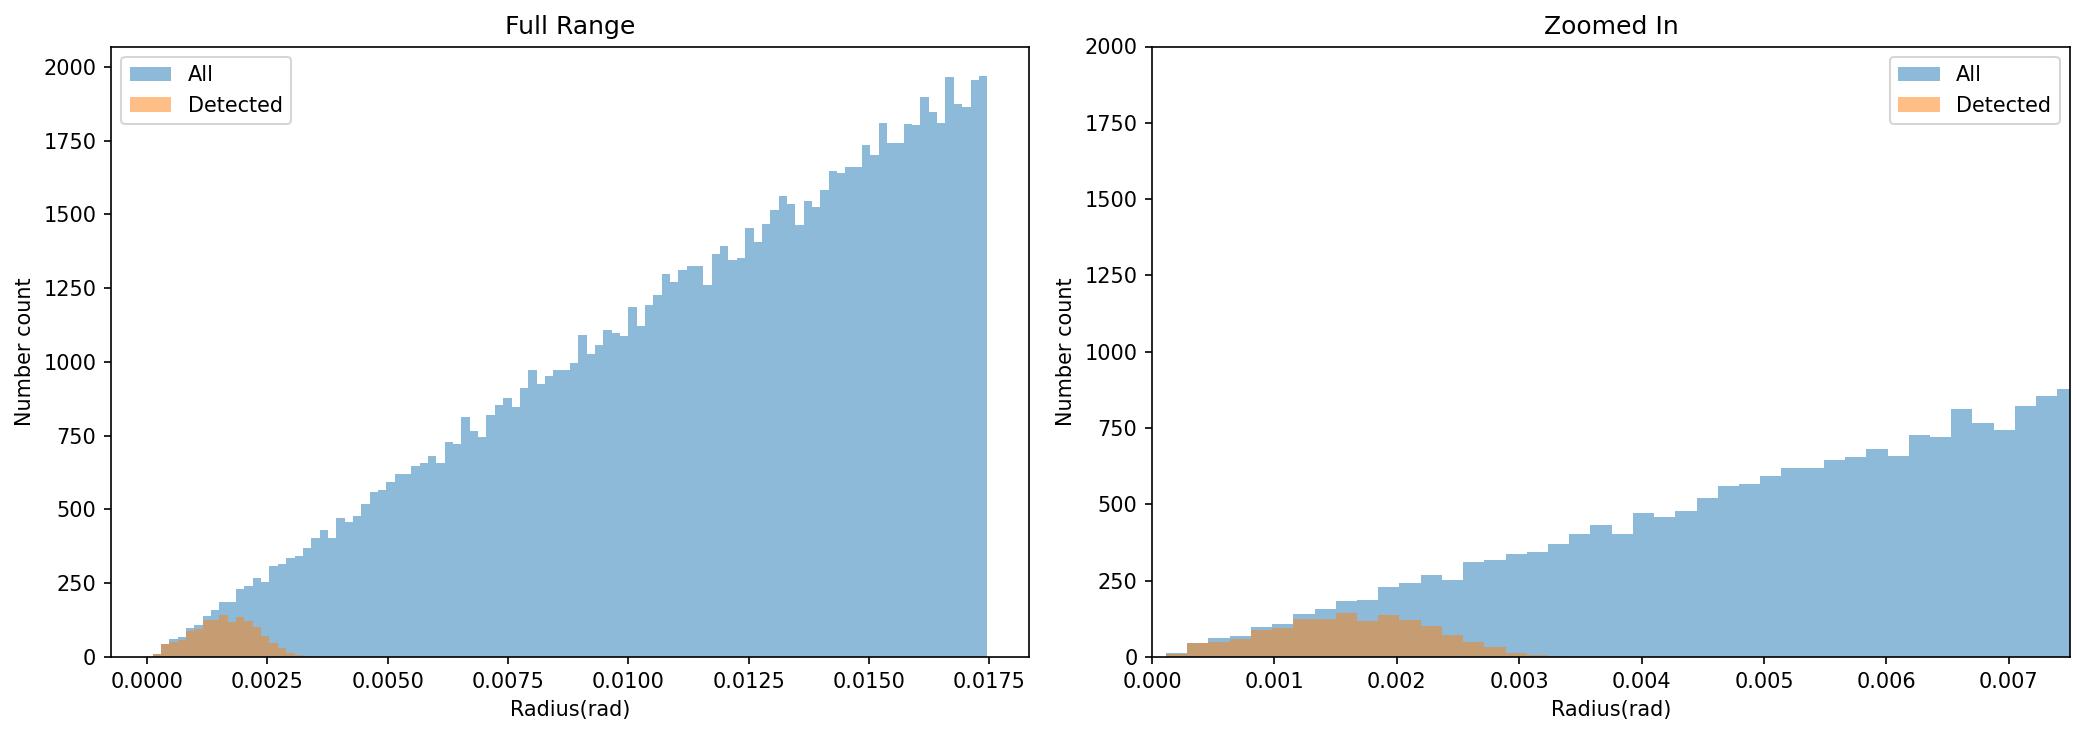

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), dpi=150)
min_val = min(min(rad), min(rad_dect))
max_val = max(max(rad), max(rad_dect))
bins = np.linspace(min_val, max_val, 101) 
# Full view
ax1.hist(rad, bins=bins, alpha=0.5, label='All')
ax1.hist(rad_dect, bins=bins, alpha=0.5, label='Detected')
ax1.set_xlabel('Radius(rad)')
ax1.set_ylabel('Number count')
ax1.legend()
ax1.set_title('Full Range')

# Zoomed view
ax2.hist(rad, bins=bins, alpha=0.5, label='All')
ax2.hist(rad_dect, bins=bins, alpha=0.5, label='Detected')
ax2.set_xlim(0, 0.0075)
ax2.set_ylim(0, 2000)
ax2.set_xlabel('Radius(rad)')
ax2.set_ylabel('Number count')
ax2.legend()
ax2.set_title('Zoomed In')

plt.tight_layout()
plt.show()

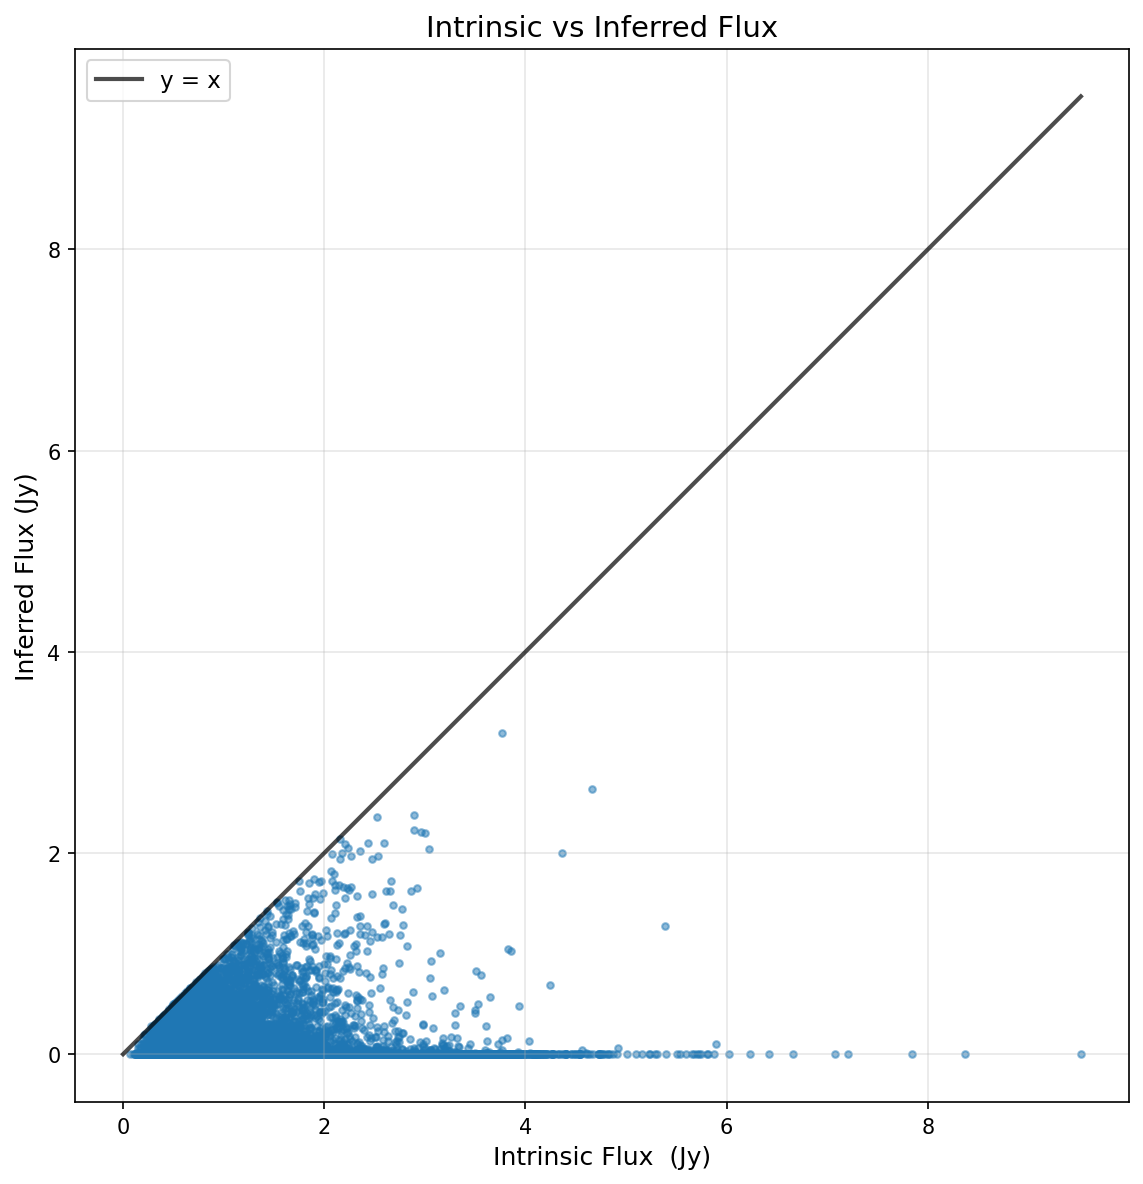

In [6]:
# Create scatter plot with 1:1 line
fig, ax = plt.subplots(figsize=(10, 8), dpi=150)

# Scatter plot
ax.scatter(S_int, S_inf, alpha=0.5, s=10)

# 1:1 reference line
min_val = min(min(S_int), min(S_inf))
max_val = max(max(S_int), max(S_inf))
ax.plot([min_val, max_val], [min_val, max_val], '-', linewidth=2, label='y = x', alpha=0.7, c = 'black')

ax.set_xlabel('Intrinsic Flux  (Jy)', fontsize=12)
ax.set_ylabel('Inferred Flux (Jy)', fontsize=12)
ax.set_title('Intrinsic vs Inferred Flux', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

In [7]:
def G0( D, eta):
    k = 1.38e-23
    return np.pi * D*D/4 * eta/2.0/k*1e-26
G0 = G0( D, 0.6) # K/Jy
S0 = 5 # flux density for central freq in Jy
nu0 = 1.4e9 # reference frequency in Hz
c = 3e8
# Frequency range
nu_min = 1.0e9  # 1.0 GHz
nu_max = 1.8e9  # 1.8 GHz




In [8]:
def flux_density(nu, S0, nu0, alpha):
    """
    Flux density as power-law function
    S(ν) = S₀ × (ν/ν₀)^α
    nu0 = reference frequency (Hz) ~1.4GHz for parkes?
    """
    return S0 * (nu / nu0)**alpha

def gaussian_beam_gain(nu, G0, theta, D, c):
    """
    Gaussian beam gain with frequency dependence
    G(ν) = G₀ × exp[−θ²ν²D²×2.355²/(2×1.22²×c²)]

    Returns:
    Gain (K/Jy)
    """
    # Exponent coefficient
    coeff = (theta**2 * D**2 * 2.355**2) / (2 * 1.22**2 * c**2)
    return G0 * np.exp(-coeff * nu**2)

def integrand(nu, S0, nu0, alpha, G0, theta, D, c):
    """Product S(ν) × G(ν)"""
    S_nu = flux_density(nu, S0, nu0, alpha)
    G_nu = gaussian_beam_gain(nu, G0, theta, D, c)
    return S_nu * G_nu

def integrate_frequency_only(nu_min, nu_max, S0, nu0, G0, D, c, n_points=2000):
    """
    Integrate over frequency, keeping α and θ as symbolic parameters
    
    Returns functions and coefficients such that:
    I(α,θ) = sum of [coefficient × function(α, θ)]
    
    The frequency integration is performed numerically for each basis function.
    """
    
    # Calculate β² coefficient (frequency-independent part)
    beta_sq = (D**2 * 2.355**2) / (2 * 1.22**2 * c**2)
    
    print("=" * 80)
    print("FREQUENCY INTEGRATION (α and θ remain symbolic)")
    print("=" * 80)
    
    print("\nOriginal integral:")
    print(f"I(α,θ) = ∫[{nu_min/1e9} to {nu_max/1e9} GHz] S₀(ν/ν₀)^α × G₀×exp(-β²θ²ν²) dν")
    print(f"\nwhere:")
    print(f"  S₀ = {S0} Jy (reference flux density at ν₀)")
    print(f"  ν₀ = {nu0/1e9} GHz (reference frequency)")
    print(f"  G₀ = {G0} K/Jy")
    print(f"  β² = {beta_sq:.6e} s²/rad² (β² is coeff in exp of G(v))")
    
    # Perform symbolic separation
    print("\n" + "-" * 80)
    print("SEPARATING α and θ DEPENDENCE")
    print("-" * 80)
    
    print("\nRewrite as:")
    print(f"I(α,θ) = S₀×G₀/ν₀^α × ∫[{nu_min/1e9} to {nu_max/1e9} GHz] ν^α × exp(-β²θ²ν²) dν")
    print(f"I(α,θ) = {S0}×{G0}/{nu0/1e9}^α × 10^(9α) × ∫ ν^α × exp(-β²θ²ν²) dν")
    
    # Now integrate numerically for a range of α values to create an interpolation
    print("\n" + "-" * 80)
    print("NUMERICAL INTEGRATION OVER FREQUENCY")
    print("-" * 80)
    
    # Create fine grid for frequency
    nu_array = np.linspace(nu_min, nu_max, n_points)
    
    # For display: compute integrals for sample α values at θ=0 and θ≠0
    alpha_samples = [-3.0, -2.5, -2.0, -1.5, -1.0, 0]
    theta_samples = [0.0, 0.001, 0.002, 0.005]
    
    print(f"\nIntegrating over frequency: ν ∈ [{nu_min/1e9}, {nu_max/1e9}] GHz")
    print(f"Number of integration points: {n_points}")
    
    # Store results in a table
    results = {}
    
    print("\n" + "=" * 80)
    print("INTEGRATED RESULTS: I(α, θ)")
    print("=" * 80)
    print(f"{'α':<8} {'θ (rad)':<12} {'θ (deg)':<12} {'I(α,θ) [K·Hz]':<18} {'Expression'}")
    print("-" * 80)
    
    for alpha_val in alpha_samples:
        results[alpha_val] = {}
        for theta_val in theta_samples:
            # Numerical integration over frequency
            integrand_array = np.zeros(n_points)
            for i, nu in enumerate(nu_array):
                integrand_array[i] = (nu**alpha_val) * np.exp(-beta_sq * theta_val**2 * nu**2)
            
            # Integrate using Simpson's rule
            integral_freq = simps(integrand_array, nu_array)
            
            # Final result including prefactor
            I_result = (S0 * G0 / nu0**alpha_val) * integral_freq
            
            results[alpha_val][theta_val] = {
                'integral_freq': integral_freq,
                'I_total': I_result
            }
            
            theta_deg = np.degrees(theta_val)
            if theta_val == 0.0:
                expr = f"({S0}×{G0}/{nu0/1e9}^{alpha_val} GHz^{alpha_val}) × {integral_freq:.4e}"
            else:
                expr = f"includes exp(-β²θ²ν²)"
            
            print(f"{alpha_val:<8.1f} {theta_val:<12.4f} {theta_deg:<12.4f} {I_result:<18.6e} {expr}")
    
    # Create symbolic representation
    print("\n" + "=" * 80)
    print("SYMBOLIC FINAL FORM")
    print("=" * 80)
    
    alpha_sym, theta_sym = sp.symbols('alpha theta', real=True)
    
    print("\nThe integrated result can be expressed as:")
    print("\n  I(α, θ) = (S₀ × G₀ / ν₀^α) × J(α, θ)")
    print(f"\n  I(α, θ) = ({S0} × {G0} / ({nu0/1e9}×10⁹)^α) × J(α, θ)")
    print(f"\nwhere J(α, θ) is the frequency-integrated factor:")
    print(f"\n  J(α, θ) = ∫[{nu_min/1e9}×10⁹ to {nu_max/1e9}×10⁹ Hz] ν^α × exp(-β²θ²ν²) dν")
    print(f"\nwith:")
    print(f"  β² = {beta_sq:.6e} s²/rad²")
    
    print("\n" + "-" * 80)
    print("EXPLICIT FORM:")
    print("-" * 80)
    print(f"\n  I(α, θ) = {S0 * G0:.4f} / ({nu0/1e9}×10⁹)^α × ∫[{nu_min/1e9}×10⁹ to {nu_max/1e9}×10⁹] ν^α × exp(-{beta_sq:.6e}×θ²×ν²) dν")
    
    print("\n" + "-" * 80)
    print("UNITS:")
    print("-" * 80)
    print("  I(α, θ) has units: K·Hz")
    print("  α is dimensionless")
    print("  θ is in radians")
    
    return results, beta_sq

def create_result_function(S0, nu0, G0, D, c, nu_min, nu_max):
    """
    Create a function that evaluates I(α, θ) by integrating over frequency
    """
    beta_sq = (D**2 * 2.355**2) / (2 * 1.22**2 * c**2)
    
    def I_integrated(alpha, theta):
        """
        Evaluate I(α, θ) where frequency integration is already performed
        """
        # Integrate over frequency only
        def freq_integrand(nu):
            return (nu**alpha) * np.exp(-beta_sq * theta**2 * nu**2)
        
        J_alpha_theta, _ = quad(freq_integrand, nu_min, nu_max)
        
        # Apply prefactor
        I_result = (S0 * G0 / nu0**alpha) * J_alpha_theta
        
        return I_result, J_alpha_theta
    
    return I_integrated



In [9]:
# =============================================================================
# Main execution
# =============================================================================

# Perform integration
results, beta_sq = integrate_frequency_only(nu_min, nu_max, S0, nu0, G0, D, c)

# Create callable function
I_func = create_result_function(S0, nu0, G0, D, c, nu_min, nu_max)



FREQUENCY INTEGRATION (α and θ remain symbolic)

Original integral:
I(α,θ) = ∫[1.0 to 1.8 GHz] S₀(ν/ν₀)^α × G₀×exp(-β²θ²ν²) dν

where:
  S₀ = 5 Jy (reference flux density at ν₀)
  ν₀ = 1.4 GHz (reference frequency)
  G₀ = 0.6993458428860757 K/Jy
  β² = 8.479097e-14 s²/rad² (β² is coeff in exp of G(v))

--------------------------------------------------------------------------------
SEPARATING α and θ DEPENDENCE
--------------------------------------------------------------------------------

Rewrite as:
I(α,θ) = S₀×G₀/ν₀^α × ∫[1.0 to 1.8 GHz] ν^α × exp(-β²θ²ν²) dν
I(α,θ) = 5×0.6993458428860757/1.4^α × 10^(9α) × ∫ ν^α × exp(-β²θ²ν²) dν

--------------------------------------------------------------------------------
NUMERICAL INTEGRATION OVER FREQUENCY
--------------------------------------------------------------------------------

Integrating over frequency: ν ∈ [1.0, 1.8] GHz
Number of integration points: 2000

INTEGRATED RESULTS: I(α, θ)
α        θ (rad)      θ (deg)      I(α,θ) [K·


GENERATING VISUALIZATION
Computing I(α, θ) over parameter space...


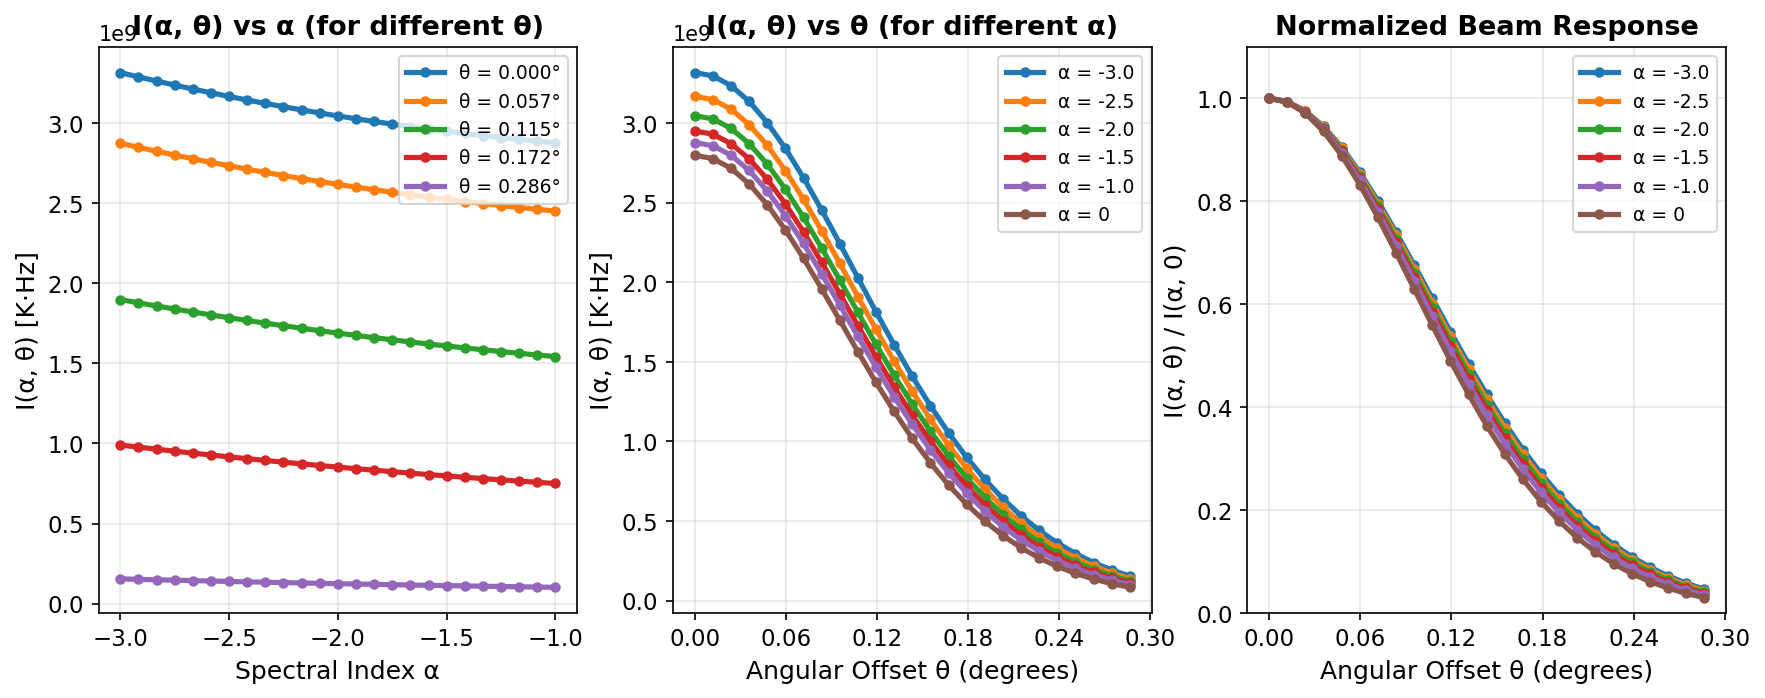

In [10]:
# =============================================================================
# Visualization
# =============================================================================
print("\n" + "=" * 80)
print("GENERATING VISUALIZATION")
print("=" * 80)

# Create parameter grids
alphas = np.linspace(-3.0, -1.0, 25)
thetas_rad = np.linspace(0, 0.005, 25)

print("Computing I(α, θ) over parameter space...")
# Only need to compute for the plots we'll use
theta_plot = [0.0, 0.001, 0.002, 0.003, 0.005]
alpha_plot = [-3.0, -2.5, -2.0, -1.5, -1.0, 0]

fig, (ax4, ax5, ax6) = plt.subplots(1, 3, figsize=(14, 5), dpi=150)

# Plot 4: I(α, θ) vs α for different θ
for theta_val in theta_plot:
    I_values = [I_func(a, theta_val)[0] for a in alphas]
    ax4.plot(alphas, I_values, linewidth=2.5, marker='o', markersize=4,
             label=f'θ = {np.degrees(theta_val):.3f}°')
ax4.set_xlabel('Spectral Index α', fontsize=12)
ax4.set_ylabel('I(α, θ) [K·Hz]', fontsize=12)
ax4.set_title('I(α, θ) vs α (for different θ)', fontsize=13, fontweight='bold')
ax4.legend(fontsize=9, loc='upper right')
ax4.grid(True, alpha=0.3)
ax4.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax4.yaxis.get_offset_text().set_fontsize(10)
ax4.tick_params(axis='both', which='major', labelsize=11)

# Plot 5: I(α, θ) vs θ for different α
for alpha_val in alpha_plot:
    I_values = [I_func(alpha_val, t)[0] for t in thetas_rad]
    ax5.plot(np.degrees(thetas_rad), I_values, linewidth=2.5, marker='o', markersize=4,
             label=f'α = {alpha_val}')
ax5.set_xlabel('Angular Offset θ (degrees)', fontsize=12)
ax5.set_ylabel('I(α, θ) [K·Hz]', fontsize=12)
ax5.set_title('I(α, θ) vs θ (for different α)', fontsize=13, fontweight='bold')
ax5.legend(fontsize=9, loc='upper right')
ax5.grid(True, alpha=0.3)
ax5.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax5.yaxis.get_offset_text().set_fontsize(10)
ax5.tick_params(axis='both', which='major', labelsize=11)
# Format x-axis to avoid overlap
ax5.xaxis.set_major_locator(plt.MaxNLocator(6))

# Plot 6: Normalized I(α, θ) / I(α, 0)
for alpha_val in alpha_plot:
    I_on_axis = I_func(alpha_val, 0.0)[0]
    I_normalized = [I_func(alpha_val, t)[0] / I_on_axis for t in thetas_rad]
    ax6.plot(np.degrees(thetas_rad), I_normalized, linewidth=2.5, marker='o', markersize=4,
             label=f'α = {alpha_val}')
ax6.set_xlabel('Angular Offset θ (degrees)', fontsize=12)
ax6.set_ylabel('I(α, θ) / I(α, 0)', fontsize=12)
ax6.set_title('Normalized Beam Response', fontsize=13, fontweight='bold')
ax6.legend(fontsize=9, loc='upper right')
ax6.grid(True, alpha=0.3)
ax6.set_ylim([0, 1.1])
ax6.tick_params(axis='both', which='major', labelsize=11)
# Format x-axis to avoid overlap
ax6.xaxis.set_major_locator(plt.MaxNLocator(6))

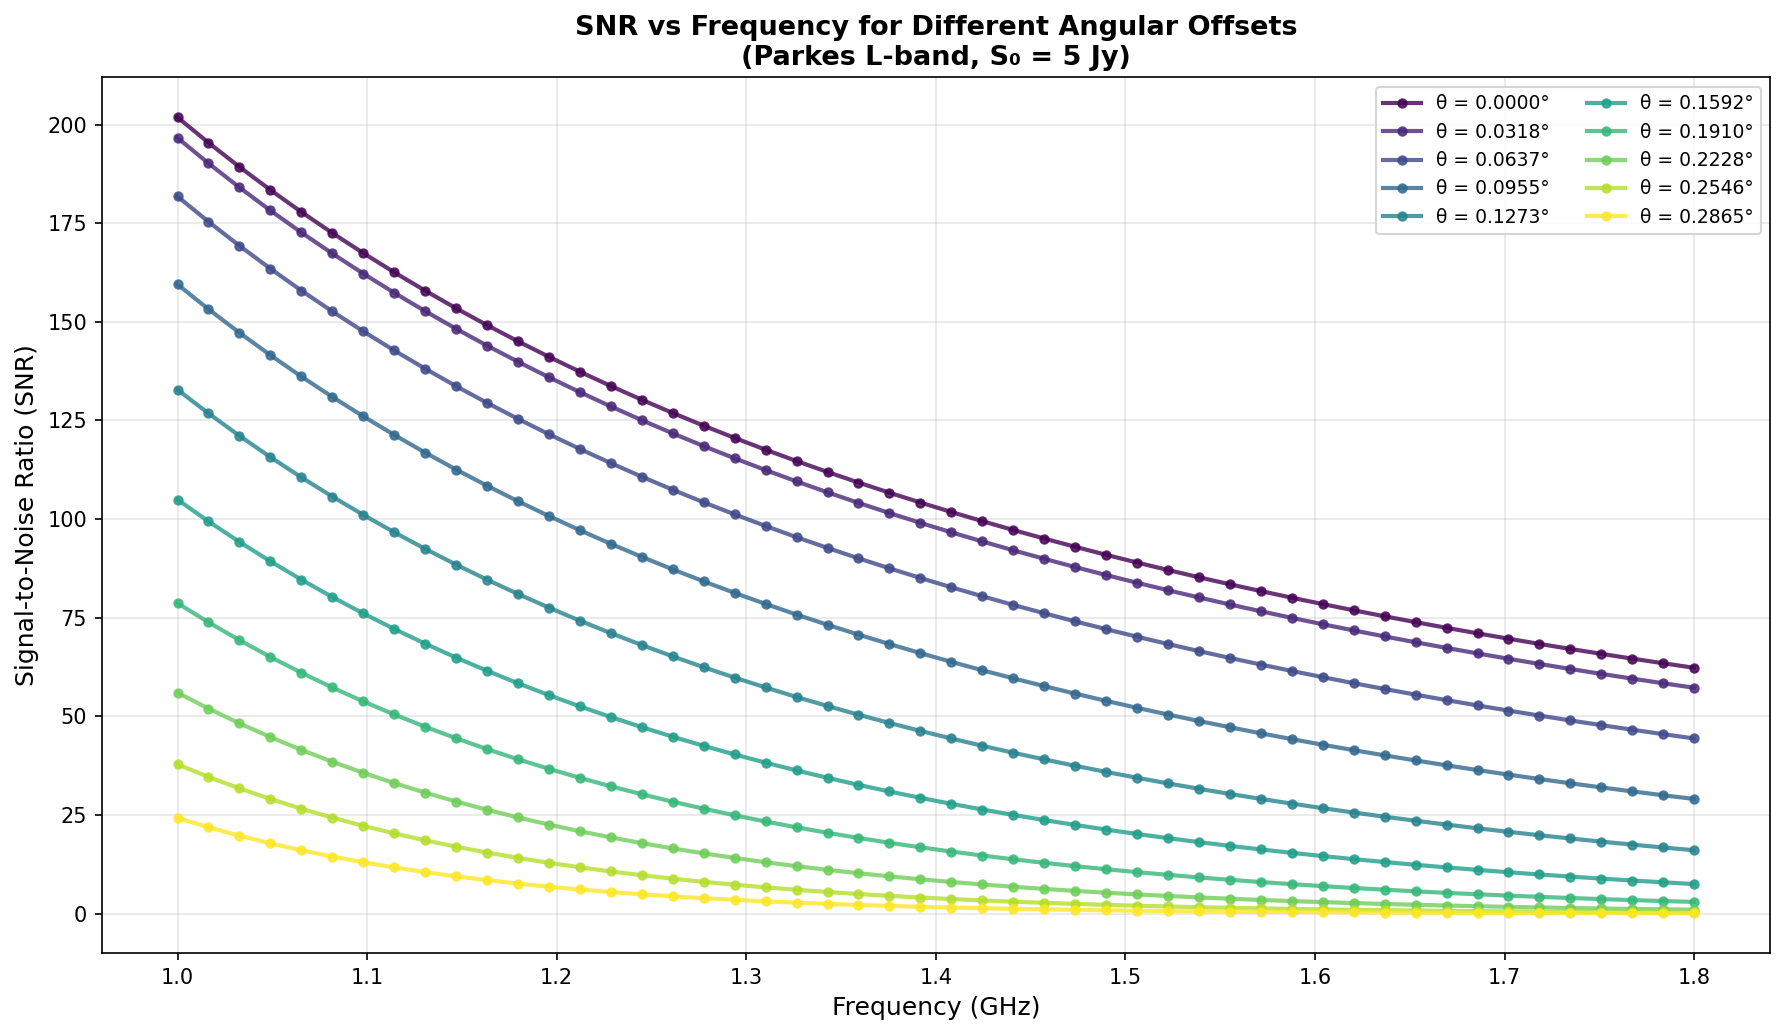

In [11]:
# Plot SNR distribution for detected sources vs frequency
fig, ax = plt.subplots(figsize=(12, 7), dpi=150)

nu_array = np.linspace(nu_min, nu_max, 50)

# Plot SNR for different positions (theta values)
theta_test_values = np.linspace(0, 0.005, 10)
colors = plt.cm.viridis(np.linspace(0, 1, len(theta_test_values)))

for i, theta_val in enumerate(theta_test_values):
    snr_spectrum = []
    
    for nu in nu_array:
        S_nu = S0*(nu / nu0)**-2  # Assume α = -2 for S(ν) , nu0 = 1.4GHz 
        G_nu = gaussian_beam_gain(nu, G0, theta_val, D, c)
        snr_val = SNR(S_nu, t, G_nu, BW, Np, Trec, Tsky)
        snr_spectrum.append(snr_val)
    
    theta_deg = np.degrees(theta_val)
    ax.plot(nu_array / 1e9, snr_spectrum, linewidth=2, marker='o', 
            markersize=4, color=colors[i], label=f'θ = {theta_deg:.4f}°', alpha=0.8)

# Detection threshold
# ax.axhline(y=8, color='r', linestyle='--', linewidth=3, label='Detection Threshold (SNR=8)', alpha=0.7)

ax.set_xlabel('Frequency (GHz)', fontsize=12)
ax.set_ylabel('Signal-to-Noise Ratio (SNR)', fontsize=12)
ax.set_title('SNR vs Frequency for Different Angular Offsets\n(Parkes L-band, S₀ = 5 Jy)', 
             fontsize=13, fontweight='bold')
ax.legend(fontsize=9, ncol=2, loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

<ipython-input-12-3ddcb992df5e>:15: RuntimeWarning: overflow encountered in power
  return a * (nu ** b)


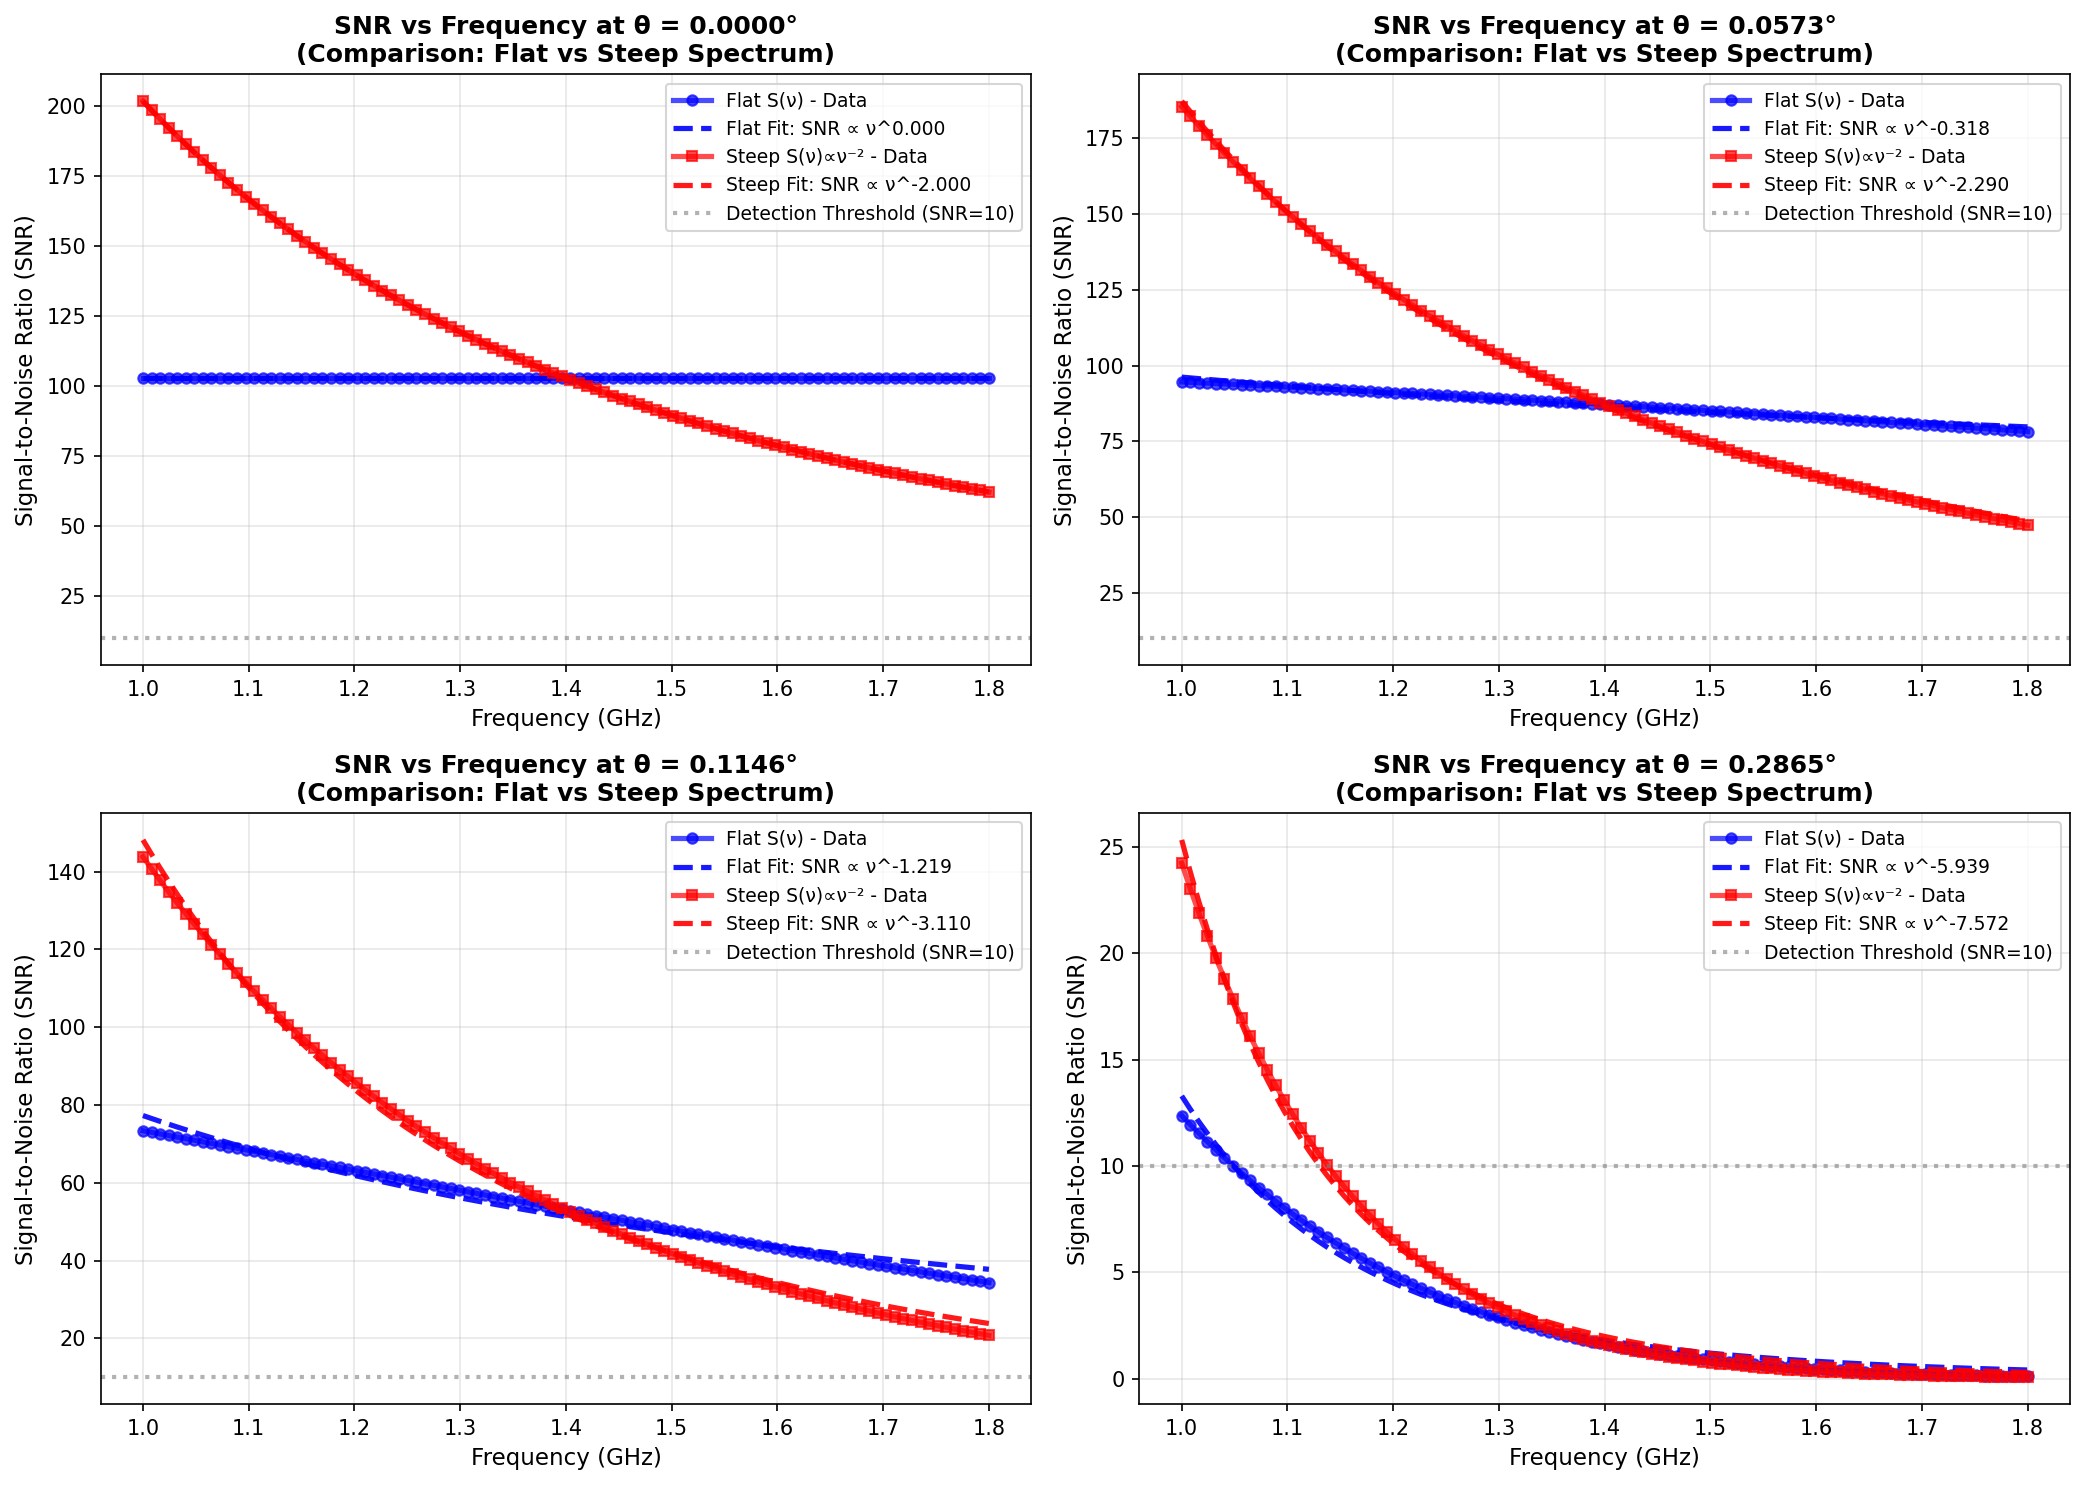


SPECTRAL INDEX COMPARISON: FLAT vs STEEP
θ (deg)      θ (rad)      Flat α       Steep α      Δα          
--------------------------------------------------------------------------------
0.0000       0.000000     0.000000     -2.000000    -2.000000   
0.0573       0.001000     -0.318249    -2.289618    -1.971369   
0.1146       0.002000     -1.219166    -3.109757    -1.890591   
0.2865       0.005000     -5.939152    -7.572396    -1.633245   

INTERPRETATION
Blue lines:  Flat spectrum   S(ν) = S₀ (constant)
Red lines:   Steep spectrum  S(ν) = S₀ × (ν/ν₀)^(-2)

Fitted α represents: SNR ∝ ν^α
  - Positive α: SNR increases with frequency
  - Negative α: SNR decreases with frequency
  - Δα = Steep α - Flat α

Key observations:
  Mean α (Flat):  -1.8691
  Mean α (Steep): -3.7429
  Mean Δα:        -1.8738


In [12]:
# Overplot flat and steep spectra for same theta values
from scipy.optimize import curve_fit

fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=150)
axes = axes.flatten()

# Different theta values
theta_values = [0.0, 0.001, 0.002, 0.005]

# Frequency range
nu_array = np.linspace(nu_min, nu_max, 100)

def power_law(nu, a, b):
    """Power law model: SNR = a * nu^b"""
    return a * (nu ** b)

fitted_results = []

for idx, theta_val in enumerate(theta_values):
    ax = axes[idx]
    
    # Calculate SNR for FLAT spectrum
    snr_spectrum_flat = []
    for nu in nu_array:
        S_nu = S0  # Flat spectrum
        G_nu = gaussian_beam_gain(nu, G0, theta_val, D, c)
        snr_val = SNR(S_nu, t, G_nu, BW, Np, Trec, Tsky)
        snr_spectrum_flat.append(snr_val)
    
    snr_spectrum_flat = np.array(snr_spectrum_flat)
    
    # Calculate SNR for STEEP spectrum
    snr_spectrum_steep = []
    for nu in nu_array:
        S_nu = S0 * (nu / nu0)**-2  # Steep spectrum
        G_nu = gaussian_beam_gain(nu, G0, theta_val, D, c)
        snr_val = SNR(S_nu, t, G_nu, BW, Np, Trec, Tsky)
        snr_spectrum_steep.append(snr_val)
    
    snr_spectrum_steep = np.array(snr_spectrum_steep)
    
    # Fit both spectra
    try:
        popt_flat, _ = curve_fit(power_law, nu_array, snr_spectrum_flat, 
                                p0=[1e-20, 2], maxfev=10000)
        a_fit_flat, b_fit_flat = popt_flat
        snr_fit_flat = power_law(nu_array, a_fit_flat, b_fit_flat)
        
        popt_steep, _ = curve_fit(power_law, nu_array, snr_spectrum_steep, 
                                 p0=[1e-20, 2], maxfev=10000)
        a_fit_steep, b_fit_steep = popt_steep
        snr_fit_steep = power_law(nu_array, a_fit_steep, b_fit_steep)
        
        fitted_results.append({
            'theta': theta_val,
            'alpha_flat': b_fit_flat,
            'alpha_steep': b_fit_steep
        })
        
        # Plot FLAT spectrum
        ax.plot(nu_array / 1e9, snr_spectrum_flat, 'b-', linewidth=2.5, 
               marker='o', markersize=5, label='Flat S(ν) - Data', alpha=0.7)
        ax.plot(nu_array / 1e9, snr_fit_flat, 'b--', linewidth=2.5, 
               label=f'Flat Fit: SNR ∝ ν^{b_fit_flat:.3f}', alpha=0.9)
        
        # Plot STEEP spectrum
        ax.plot(nu_array / 1e9, snr_spectrum_steep, 'r-', linewidth=2.5, 
               marker='s', markersize=5, label='Steep S(ν)∝ν⁻² - Data', alpha=0.7)
        ax.plot(nu_array / 1e9, snr_fit_steep, 'r--', linewidth=2.5, 
               label=f'Steep Fit: SNR ∝ ν^{b_fit_steep:.3f}', alpha=0.9)
        
    except Exception as e:
        print(f"Fit failed for theta={theta_val}: {e}")
        ax.plot(nu_array / 1e9, snr_spectrum_flat, 'b-', linewidth=2.5, marker='o')
        ax.plot(nu_array / 1e9, snr_spectrum_steep, 'r-', linewidth=2.5, marker='s')
    
    # Add detection threshold
    ax.axhline(y=10, color='gray', linestyle=':', linewidth=2, 
              label='Detection Threshold (SNR=10)', alpha=0.6)
    
    ax.set_xlabel('Frequency (GHz)', fontsize=11)
    ax.set_ylabel('Signal-to-Noise Ratio (SNR)', fontsize=11)
    theta_deg = np.degrees(theta_val)
    ax.set_title(f'SNR vs Frequency at θ = {theta_deg:.4f}°\n(Comparison: Flat vs Steep Spectrum)', 
                fontsize=12, fontweight='bold')
    ax.legend(fontsize=9, loc='best')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print comparison results
print("\n" + "=" * 80)
print("SPECTRAL INDEX COMPARISON: FLAT vs STEEP")
print("=" * 80)
print(f"{'θ (deg)':<12} {'θ (rad)':<12} {'Flat α':<12} {'Steep α':<12} {'Δα':<12}")
print("-" * 80)

for result in fitted_results:
    theta_deg = np.degrees(result['theta'])
    delta_alpha = result['alpha_steep'] - result['alpha_flat']
    print(f"{theta_deg:<12.4f} {result['theta']:<12.6f} {result['alpha_flat']:<12.6f} "
          f"{result['alpha_steep']:<12.6f} {delta_alpha:<12.6f}")

print("\n" + "=" * 80)
print("INTERPRETATION")
print("=" * 80)
print("Blue lines:  Flat spectrum   S(ν) = S₀ (constant)")
print("Red lines:   Steep spectrum  S(ν) = S₀ × (ν/ν₀)^(-2)")
print("\nFitted α represents: SNR ∝ ν^α")
print("  - Positive α: SNR increases with frequency")
print("  - Negative α: SNR decreases with frequency")
print("  - Δα = Steep α - Flat α")
print("\nKey observations:")
print(f"  Mean α (Flat):  {np.nanmean([r['alpha_flat'] for r in fitted_results]):.4f}")
print(f"  Mean α (Steep): {np.nanmean([r['alpha_steep'] for r in fitted_results]):.4f}")
print(f"  Mean Δα:        {np.nanmean([r['alpha_steep'] - r['alpha_flat'] for r in fitted_results]):.4f}")

Flat Spectral Indices

In [13]:
# Generate 10000 FRBs with log-normal S0, Gaussian intrinsic α, random θ
# Compare intrinsic vs observed spectral indices


In [14]:

np.random.seed(42)

n_frb = 1000
nu_array = np.linspace(nu_min, nu_max, 50)

# FRB properties
frb_S0 = []  # Flux density at reference frequency (log-normal)
frb_alpha_intrinsic = []  # Intrinsic spectral index (Gaussian centered at -2)
frb_theta = []  # Angular offset (Gaussian distribution)
frb_alpha_inferred = []  # Observed spectral index (fitted)
frb_snr = []  # SNR at reference frequency
frb_detected = []  # Detection flag
frb_snr_coherent = []

# Parameters
S0_mean = 1
S0_sigma = 0.5
alpha_mean = -2.0  # Gaussian center at -2
alpha_sigma = 0.5  # Standard deviation of spectral index
# theta_mean = 0.0
# theta_sigma = 0.002  # Gaussian angular offset (rad)
theta_min = 0.0
theta_max = 0.005  # UNIFORM angular offset (rad) from 0 to 0.005
BW = 50e6 # Lband 1-1.8 GHz 16 channels

In [15]:


print("=" * 80)
print("GENERATING 10000 FRB POPULATION")
print("=" * 80)
print(f"\nFlux Density S₀ (at ν₀ = {nu0/1e9} GHz):")
print(f"  Distribution: Log-normal")
print(f"  Mean: {S0_mean} Jy")
print(f"  σ: {S0_sigma}")

print(f"\nIntrinsic Spectral Index α_intrinsic:")
print(f"  Distribution: Uniform")
print(f"  Range: [0, -5]")

print(f"\nAngular Offset θ:")
print(f"  Distribution: Gaussian (Normal)")


print(f"\nCalculating observed spectral index from frequency-dependent SNR...")
print(f"Frequency range: {nu_min/1e9} - {nu_max/1e9} GHz ({len(nu_array)} points)")

# Generate FRBs
for i in range(n_frb):
    if (i + 1) % 2000 == 0:
        print(f"  Processing FRB {i+1}/{n_frb}...")
    
    # S0: Log-normal distribution
    mu = np.log(S0_mean) - S0_sigma**2 / 2.0
    S0_frb = np.random.lognormal(mean=mu, sigma=S0_sigma)
    frb_S0.append(S0_frb)
    
    # Intrinsic spectral index: Uniform between 0 and -5
    alpha_intrinsic = np.random.uniform(0, -5)
    frb_alpha_intrinsic.append(alpha_intrinsic)
    
    # Angular offset: Uniform distribution between 0 and theta_max
    theta_frb = theta_max * np.sqrt(np.random.random())
    theta_frb = np.abs(theta_frb)  # Ensure positive
    frb_theta.append(theta_frb)
    
    # Calculate SNR spectrum across frequency band
    snr_spectrum = []
    for nu in nu_array:
        S_nu = S0_frb * (nu / nu0)**alpha_intrinsic
        G_nu = gaussian_beam_gain(nu, G0, theta_frb, D, c)
        snr_val = SNR(S_nu, t, G_nu, BW, Np, Trec, Tsky)
        snr_spectrum.append(snr_val)
    
    snr_spectrum = np.array(snr_spectrum)
    
    # SNR at reference frequency
    S_nu0 = S0_frb
    G_nu0 = gaussian_beam_gain(nu0, G0, theta_frb, D, c)
    snr_nu0 = SNR(S_nu0, t, G_nu0, BW, Np, Trec, Tsky)
    frb_snr.append(snr_nu0)
    
    # Detection criterion
    snr_coherent = np.sqrt(np.sum(snr_spectrum**2) / len(snr_spectrum))
    frb_snr_coherent.append(snr_coherent) 
    frb_detected.append(snr_coherent > 10)
    
    # Fit observed spectral index: SNR ∝ ν^α_obs
    try:
        def power_law(nu, a, b):
            return a * (nu ** b)
        
        popt, _ = curve_fit(power_law, nu_array, snr_spectrum, 
                           p0=[1e-20, 2], maxfev=5000)
        a_fit, alpha_observed = popt
        frb_alpha_inferred.append(alpha_observed)
    except:
        frb_alpha_inferred.append(np.nan)

# Convert to arrays
frb_S0 = np.array(frb_S0)
frb_alpha_intrinsic = np.array(frb_alpha_intrinsic)
frb_theta = np.array(frb_theta)
frb_alpha_inferred = np.array(frb_alpha_inferred)
frb_snr = np.array(frb_snr)
frb_detected = np.array(frb_detected)

n_detected = np.sum(frb_detected)
detection_rate = n_detected / n_frb * 100

print(f"\n" + "=" * 80)
print("FRB POPULATION STATISTICS")
print("=" * 80)

print(f"\nFlux Density S₀:")
print(f"  Mean:     {np.mean(frb_S0):.4f} Jy")
print(f"  Median:   {np.median(frb_S0):.4f} Jy")
print(f"  Std Dev:  {np.std(frb_S0):.4f} Jy")

print(f"\nIntrinsic Spectral Index α_intrinsic:")
print(f"  Mean:     {np.mean(frb_alpha_intrinsic):.4f}")
print(f"  Median:   {np.median(frb_alpha_intrinsic):.4f}")
print(f"  Std Dev:  {np.std(frb_alpha_intrinsic):.4f}")

print(f"\nObserved Spectral Index α_observed:")
alpha_obs_valid = frb_alpha_inferred[~np.isnan(frb_alpha_inferred)]
print(f"  Mean:     {np.mean(alpha_obs_valid):.4f}")
print(f"  Median:   {np.median(alpha_obs_valid):.4f}")
print(f"  Std Dev:  {np.std(alpha_obs_valid):.4f}")
print(f"  Valid fits: {len(alpha_obs_valid)}/{n_frb}")

print(f"\nAngular Offset θ:")
print(f"  Mean:     {np.degrees(np.mean(frb_theta)):.6f}°")
print(f"  Median:   {np.degrees(np.median(frb_theta)):.6f}°")
print(f"  Std Dev:  {np.degrees(np.std(frb_theta)):.6f}°")

print(f"\nSNR at Reference Frequency (ν₀ = {nu0/1e9} GHz):")
print(f"  Mean:     {np.mean(frb_snr):.4f}")
print(f"  Median:   {np.median(frb_snr):.4f}")
print(f"  Std Dev:  {np.std(frb_snr):.4f}")

print(f"\nDetection Statistics:")
print(f"  Total FRBs:      {n_frb}")
print(f"  Detected (SNR>8):{n_detected}")
print(f"  Detection Rate:  {detection_rate:.2f}%")

print("\n" + "=" * 80)
frb_detected_flat = frb_detected

GENERATING 10000 FRB POPULATION

Flux Density S₀ (at ν₀ = 1.4 GHz):
  Distribution: Log-normal
  Mean: 1 Jy
  σ: 0.5

Intrinsic Spectral Index α_intrinsic:
  Distribution: Uniform
  Range: [0, -5]

Angular Offset θ:
  Distribution: Gaussian (Normal)

Calculating observed spectral index from frequency-dependent SNR...
Frequency range: 1.0 - 1.8 GHz (50 points)

FRB POPULATION STATISTICS

Flux Density S₀:
  Mean:     1.0195 Jy
  Median:   0.9127 Jy
  Std Dev:  0.5076 Jy

Intrinsic Spectral Index α_intrinsic:
  Mean:     -2.4265
  Median:   -2.4358
  Std Dev:  1.4696

Observed Spectral Index α_observed:
  Mean:     -5.2405
  Median:   -5.4081
  Std Dev:  1.8930
  Valid fits: 968/1000

Angular Offset θ:
  Mean:     0.190793°
  Median:   0.201702°
  Std Dev:  0.066410°

SNR at Reference Frequency (ν₀ = 1.4 GHz):
  Mean:     1.8881
  Median:   0.9000
  Std Dev:  2.3873

Detection Statistics:
  Total FRBs:      1000
  Detected (SNR>8):65
  Detection Rate:  6.50%



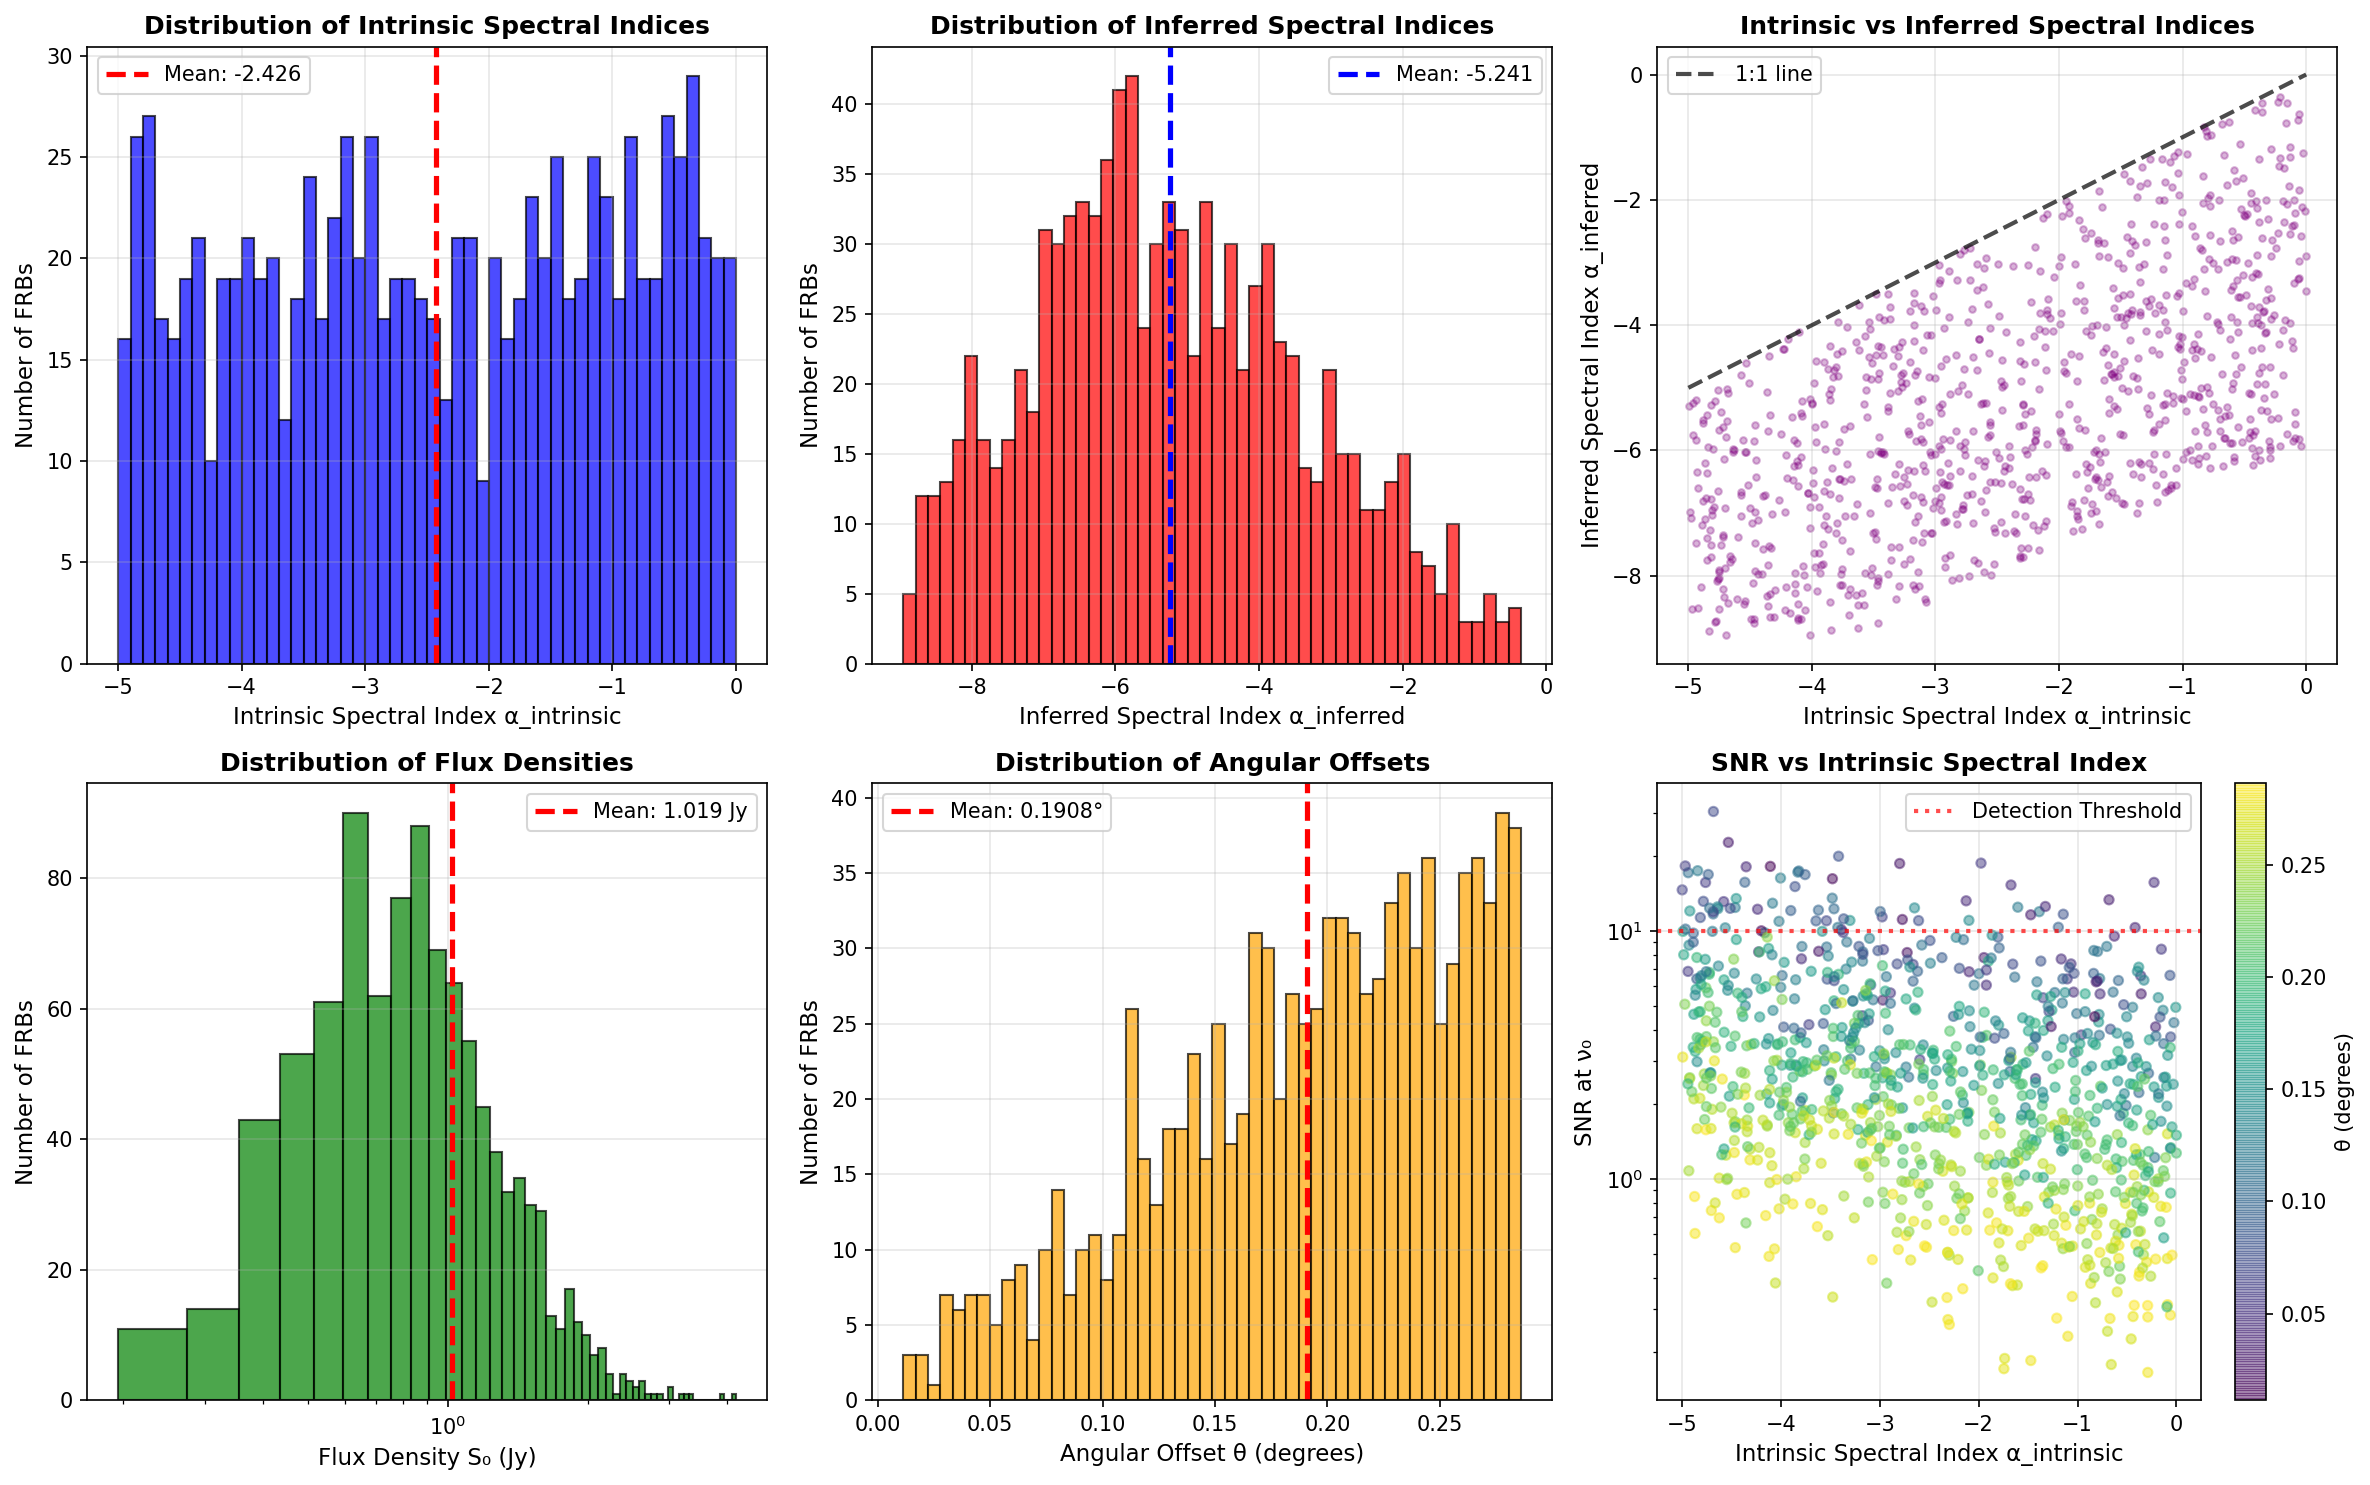


SPECTRAL INDEX ANALYSIS

Difference (α_obs - α_intrinsic):
  Mean:     -2.8107
  Median:   -2.8663
  Std Dev:  2.3965
  Min:      -8.6140
  Max:      4.3690

Observations:
  - Intrinsic α spans from 0 to -5 (uniform distribution)
  - Observed α is affected by:
    • Frequency-dependent beam gain
    • Angular position (θ)
    • SNR variation across frequency band



In [16]:
# Plot histograms and comparisons
fig, axes = plt.subplots(2, 3, figsize=(16, 10), dpi=150)

# Plot 1: Intrinsic spectral index distribution
ax = axes[0, 0]
ax.hist(frb_alpha_intrinsic, bins=50, alpha=0.7, color='blue', edgecolor='black')
ax.axvline(np.mean(frb_alpha_intrinsic), color='red', linestyle='--', linewidth=2.5, 
           label=f'Mean: {np.mean(frb_alpha_intrinsic):.3f}')
ax.set_xlabel('Intrinsic Spectral Index α_intrinsic', fontsize=11)
ax.set_ylabel('Number of FRBs', fontsize=11)
ax.set_title('Distribution of Intrinsic Spectral Indices', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 2: Observed spectral index distribution
ax = axes[0, 1]
alpha_obs_valid = frb_alpha_inferred[~np.isnan(frb_alpha_inferred)]
ax.hist(alpha_obs_valid, bins=50, alpha=0.7, color='red', edgecolor='black')
ax.axvline(np.mean(alpha_obs_valid), color='blue', linestyle='--', linewidth=2.5, 
           label=f'Mean: {np.mean(alpha_obs_valid):.3f}')
ax.set_xlabel('Inferred Spectral Index α_inferred', fontsize=11)
ax.set_ylabel('Number of FRBs', fontsize=11)
ax.set_title('Distribution of Inferred Spectral Indices', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 3: Intrinsic vs Observed (scatter)
ax = axes[0, 2]
ax.scatter(frb_alpha_intrinsic, frb_alpha_inferred, alpha=0.3, s=10, color='purple')
ax.plot([-5, 0], [-5, 0], 'k--', linewidth=2, label='1:1 line', alpha=0.7)
ax.set_xlabel('Intrinsic Spectral Index α_intrinsic', fontsize=11)
ax.set_ylabel('Inferred Spectral Index α_inferred', fontsize=11)
ax.set_title('Intrinsic vs Inferred Spectral Indices', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 4: S0 distribution
ax = axes[1, 0]
ax.hist(frb_S0, bins=50, alpha=0.7, color='green', edgecolor='black')
ax.axvline(np.mean(frb_S0), color='red', linestyle='--', linewidth=2.5, 
           label=f'Mean: {np.mean(frb_S0):.3f} Jy')
ax.set_xlabel('Flux Density S₀ (Jy)', fontsize=11)
ax.set_ylabel('Number of FRBs', fontsize=11)
ax.set_title('Distribution of Flux Densities', fontsize=12, fontweight='bold')
ax.set_xscale('log')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 5: Angular offset distribution
ax = axes[1, 1]
ax.hist(np.degrees(frb_theta), bins=50, alpha=0.7, color='orange', edgecolor='black')
ax.axvline(np.degrees(np.mean(frb_theta)), color='red', linestyle='--', linewidth=2.5, 
           label=f'Mean: {np.degrees(np.mean(frb_theta)):.4f}°')
ax.set_xlabel('Angular Offset θ (degrees)', fontsize=11)
ax.set_ylabel('Number of FRBs', fontsize=11)
ax.set_title('Distribution of Angular Offsets', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 6: SNR vs intrinsic spectral index
ax = axes[1, 2]
scatter = ax.scatter(frb_alpha_intrinsic, frb_snr_coherent, c=np.degrees(frb_theta), 
                     cmap='viridis', alpha=0.5, s=20)
ax.axhline(y=10, color='red', linestyle=':', linewidth=2, label='Detection Threshold', alpha=0.7)
ax.set_xlabel('Intrinsic Spectral Index α_intrinsic', fontsize=11)
ax.set_ylabel('SNR at ν₀', fontsize=11)
ax.set_title('SNR vs Intrinsic Spectral Index', fontsize=12, fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('θ (degrees)', fontsize=10)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

plt.tight_layout()
plt.show()

# Print spectral index comparison
print("\n" + "=" * 80)
print("SPECTRAL INDEX ANALYSIS")
print("=" * 80)

delta_alpha = alpha_obs_valid - frb_alpha_intrinsic[:len(alpha_obs_valid)]
print(f"\nDifference (α_obs - α_intrinsic):")
print(f"  Mean:     {np.mean(delta_alpha):.4f}")
print(f"  Median:   {np.median(delta_alpha):.4f}")
print(f"  Std Dev:  {np.std(delta_alpha):.4f}")
print(f"  Min:      {np.min(delta_alpha):.4f}")
print(f"  Max:      {np.max(delta_alpha):.4f}")

print(f"\nObservations:")
print(f"  - Intrinsic α spans from 0 to -5 (uniform distribution)")
print(f"  - Observed α is affected by:")
print(f"    • Frequency-dependent beam gain")
print(f"    • Angular position (θ)")
print(f"    • SNR variation across frequency band")
print("\n" + "=" * 80)

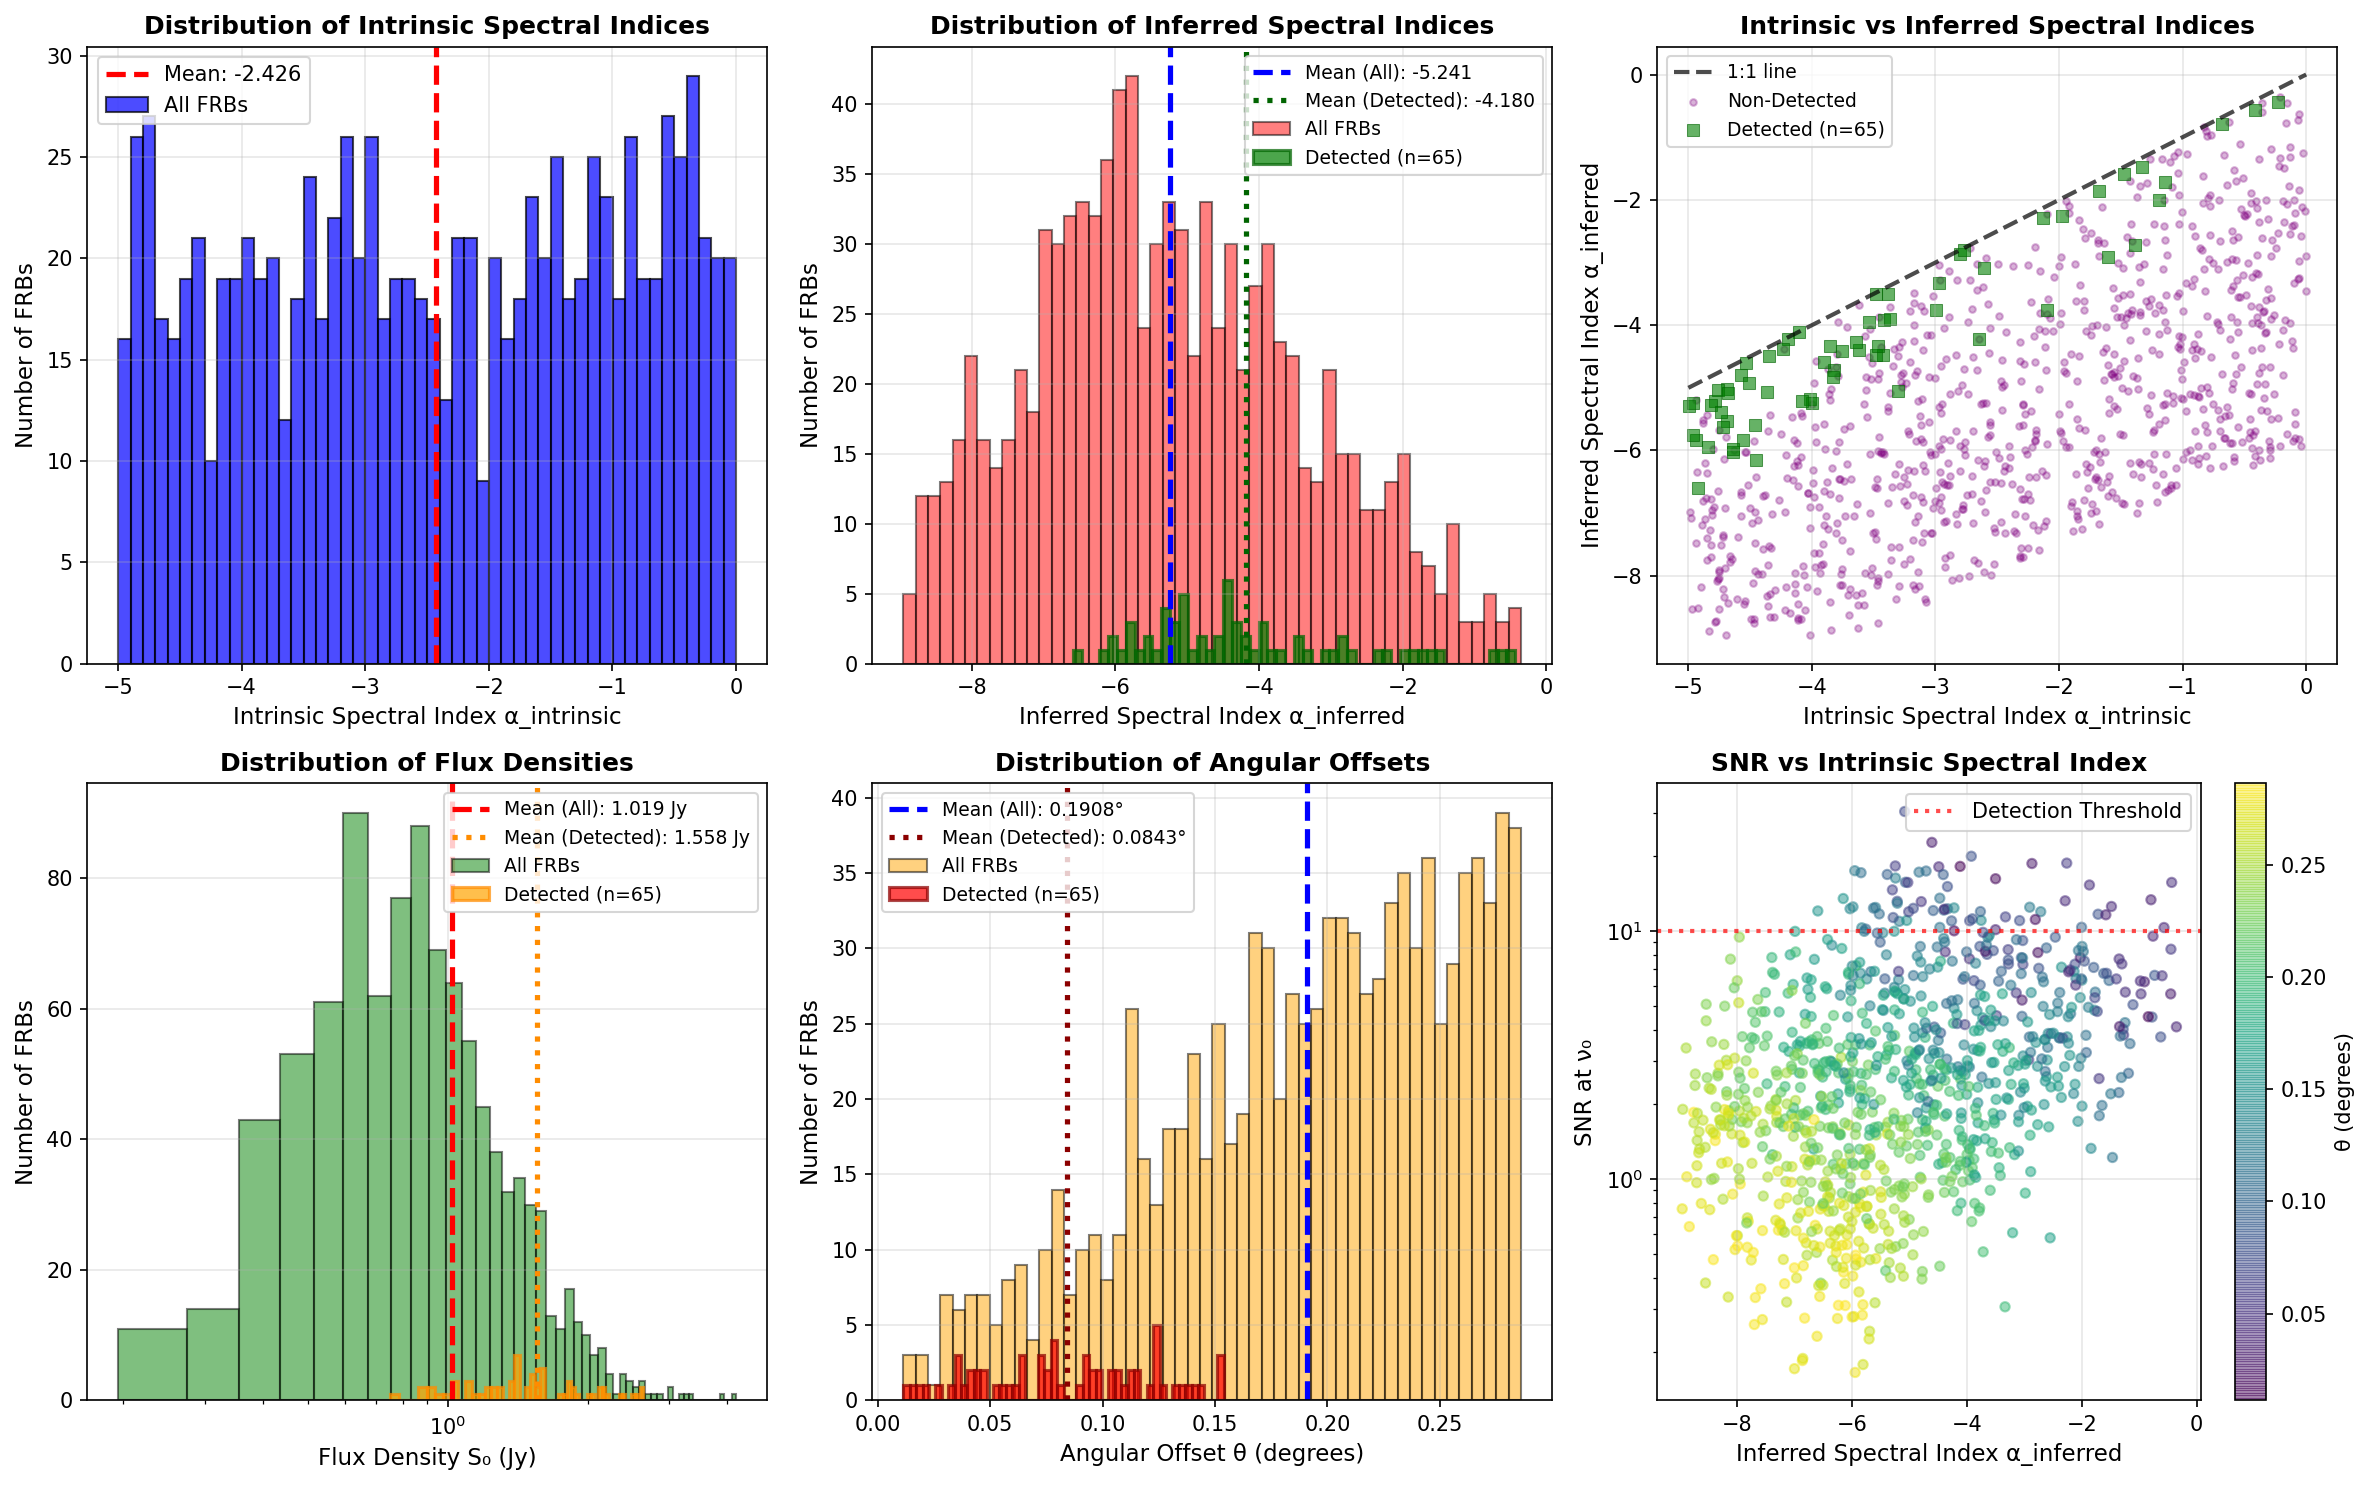

In [ ]:
# Plot histograms and comparisons
fig, axes = plt.subplots(2, 3, figsize=(16, 10), dpi=150)

# Plot 1: Intrinsic spectral index distribution
ax = axes[0, 0]
ax.hist(frb_alpha_intrinsic, bins=50, alpha=0.7, color='blue', edgecolor='black', label='All FRBs')
ax.axvline(np.mean(frb_alpha_intrinsic), color='red', linestyle='--', linewidth=2.5, 
           label=f'Mean: {np.mean(frb_alpha_intrinsic):.3f}')
ax.set_xlabel('Intrinsic Spectral Index α_intrinsic', fontsize=11)
ax.set_ylabel('Number of FRBs', fontsize=11)
ax.set_title('Distribution of Intrinsic Spectral Indices', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 2: Inferred spectral index distribution (with detected overlay)
ax = axes[0, 1]
alpha_inferred_valid = frb_alpha_inferred[~np.isnan(frb_alpha_inferred)]
ax.hist(alpha_inferred_valid, bins=50, alpha=0.5, color='red', edgecolor='black', label='All FRBs')

# Overlay histogram of detected FRBs
alpha_inferred_detected = frb_alpha_inferred[frb_detected & ~np.isnan(frb_alpha_inferred)]
ax.hist(alpha_inferred_detected, bins=50, alpha=0.7, color='green', edgecolor='darkgreen', 
        linewidth=1.5, label=f'Detected (n={len(alpha_inferred_detected)})')

ax.axvline(np.mean(alpha_inferred_valid), color='blue', linestyle='--', linewidth=2.5, 
           label=f'Mean (All): {np.mean(alpha_inferred_valid):.3f}')
ax.axvline(np.mean(alpha_inferred_detected), color='darkgreen', linestyle=':', linewidth=2.5, 
           label=f'Mean (Detected): {np.mean(alpha_inferred_detected):.3f}')
ax.set_xlabel('Inferred Spectral Index α_inferred', fontsize=11)
ax.set_ylabel('Number of FRBs', fontsize=11)
ax.set_title('Distribution of Inferred Spectral Indices', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 3: Intrinsic vs Inferred (scatter with detected labeled)
ax = axes[0, 2]
# Plot non-detected FRBs
non_detected_mask = ~frb_detected & ~np.isnan(frb_alpha_inferred)
ax.scatter(frb_alpha_intrinsic[non_detected_mask], frb_alpha_inferred[non_detected_mask], 
           alpha=0.3, s=10, color='purple', label='Non-Detected')

# Plot detected FRBs with different color/marker
detected_mask = frb_detected & ~np.isnan(frb_alpha_inferred)
ax.scatter(frb_alpha_intrinsic[detected_mask], frb_alpha_inferred[detected_mask], 
           alpha=0.6, s=30, color='green', marker='s', edgecolor='darkgreen', linewidth=0.5,
           label=f'Detected (n={np.sum(detected_mask)})')

ax.plot([-5, 0], [-5, 0], 'k--', linewidth=2, label='1:1 line', alpha=0.7)
ax.set_xlabel('Intrinsic Spectral Index α_intrinsic', fontsize=11)
ax.set_ylabel('Inferred Spectral Index α_inferred', fontsize=11)
ax.set_title('Intrinsic vs Inferred Spectral Indices', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 4: S0 distribution (with detected overlay)
ax = axes[1, 0]
ax.hist(frb_S0, bins=50, alpha=0.5, color='green', edgecolor='black', label='All FRBs')

# Overlay histogram of detected FRBs
S0_detected = frb_S0[frb_detected]
ax.hist(S0_detected, bins=50, alpha=0.7, color='orange', edgecolor='darkorange', 
        linewidth=1.5, label=f'Detected (n={len(S0_detected)})')

ax.axvline(np.mean(frb_S0), color='red', linestyle='--', linewidth=2.5, 
           label=f'Mean (All): {np.mean(frb_S0):.3f} Jy')
ax.axvline(np.mean(S0_detected), color='darkorange', linestyle=':', linewidth=2.5, 
           label=f'Mean (Detected): {np.mean(S0_detected):.3f} Jy')
ax.set_xlabel('Flux Density S₀ (Jy)', fontsize=11)
ax.set_ylabel('Number of FRBs', fontsize=11)
ax.set_title('Distribution of Flux Densities', fontsize=12, fontweight='bold')
ax.set_xscale('log')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 5: Angular offset distribution (with detected overlay)
ax = axes[1, 1]
ax.hist(np.degrees(frb_theta), bins=50, alpha=0.5, color='orange', edgecolor='black', label='All FRBs')

# Overlay histogram of detected FRBs
theta_detected = np.degrees(frb_theta[frb_detected])
ax.hist(theta_detected, bins=50, alpha=0.7, color='red', edgecolor='darkred', 
        linewidth=1.5, label=f'Detected (n={len(theta_detected)})')

ax.axvline(np.degrees(np.mean(frb_theta)), color='blue', linestyle='--', linewidth=2.5, 
           label=f'Mean (All): {np.degrees(np.mean(frb_theta)):.4f}°')
ax.axvline(np.degrees(np.mean(frb_theta[frb_detected])), color='darkred', linestyle=':', linewidth=2.5, 
           label=f'Mean (Detected): {np.degrees(np.mean(frb_theta[frb_detected])):.4f}°')
ax.set_xlabel('Angular Offset θ (degrees)', fontsize=11)
ax.set_ylabel('Number of FRBs', fontsize=11)
ax.set_title('Distribution of Angular Offsets', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 6: SNR vs intrinsic spectral index
ax = axes[1, 2]
scatter = ax.scatter(frb_alpha_inferred, frb_snr_coherent, c=np.degrees(frb_theta), 
                     cmap='viridis', alpha=0.5, s=20)
ax.axhline(y=10, color='red', linestyle=':', linewidth=2, label='Detection Threshold', alpha=0.7)
ax.set_xlabel('Inferred Spectral Index α_inferred', fontsize=11)
ax.set_ylabel('SNR at ν₀', fontsize=11)
ax.set_title('SNR vs Intrinsic Spectral Index', fontsize=12, fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('θ (degrees)', fontsize=10)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

plt.tight_layout()
plt.show()



In [18]:
# FRB properties
frb_S0 = []  # Flux density at reference frequency (log-normal)
frb_alpha_intrinsic = []  # Intrinsic spectral index (Gaussian centered at -2)
frb_theta = []  # Angular offset (Gaussian distribution)
frb_alpha_inferred = []  # Observed spectral index (fitted)
frb_snr = []  # SNR at reference frequency
frb_detected = []  # Detection flag
frb_snr_coherent = [] 


# Generate FRBs
for i in range(n_frb):
    if (i + 1) % 2000 == 0:
        print(f"  Processing FRB {i+1}/{n_frb}...")
    
    # S0: Log-normal distribution
    mu = np.log(S0_mean) - S0_sigma**2 / 2.0
    S0_frb = np.random.lognormal(mean=mu, sigma=S0_sigma)
    frb_S0.append(S0_frb)
    
    # Intrinsic spectral index: Gaussian centered at -2
    alpha_intrinsic = np.random.normal(loc=alpha_mean, scale=alpha_sigma)
    frb_alpha_intrinsic.append(alpha_intrinsic)
    
    # Angular offset: Gaussian distribution
    theta_frb = theta_max * np.sqrt(np.random.random())
    theta_frb = np.abs(theta_frb)  # Ensure positive
    frb_theta.append(theta_frb)
    
    # Calculate SNR spectrum across frequency band
    snr_spectrum = []
    for nu in nu_array:
        S_nu = S0_frb * (nu / nu0)**alpha_intrinsic
        G_nu = gaussian_beam_gain(nu, G0, theta_frb, D, c)
        snr_val = SNR(S_nu, t, G_nu, BW, Np, Trec, Tsky)
        snr_spectrum.append(snr_val)
    
    snr_spectrum = np.array(snr_spectrum)
    
    # SNR at reference frequency
    S_nu0 = S0_frb
    G_nu0 = gaussian_beam_gain(nu0, G0, theta_frb, D, c)
    snr_nu0 = SNR(S_nu0, t, G_nu0, BW, Np, Trec, Tsky)
    frb_snr.append(snr_nu0)
    
    #Detection criterion: sqrt(sum(SNR_i)/N) > 10
    snr_coherent = np.sqrt(np.sum(snr_spectrum**2) / len(snr_spectrum))
    frb_snr_coherent.append(snr_coherent)  # 新增：記錄相干 SNR
    frb_detected.append(snr_coherent > 10)
    
    
    # Fit observed spectral index: SNR ∝ ν^α_obs
    try:
        def power_law(nu, a, b):
            return a * (nu ** b)
        
        popt, _ = curve_fit(power_law, nu_array, snr_spectrum, 
                           p0=[1e-20, 2], maxfev=5000)
        a_fit, alpha_observed = popt
        frb_alpha_inferred.append(alpha_observed)
    except:
        frb_alpha_inferred.append(np.nan)

# Convert to arrays
frb_S0 = np.array(frb_S0)
frb_alpha_intrinsic = np.array(frb_alpha_intrinsic)
frb_theta = np.array(frb_theta)
frb_alpha_inferred = np.array(frb_alpha_inferred)
frb_snr = np.array(frb_snr)
frb_detected = np.array(frb_detected)

n_detected = np.sum(frb_detected)
detection_rate = n_detected / n_frb * 100


alpha_obs_valid = frb_alpha_inferred[~np.isnan(frb_alpha_inferred)]

frb_detected_norm = frb_detected

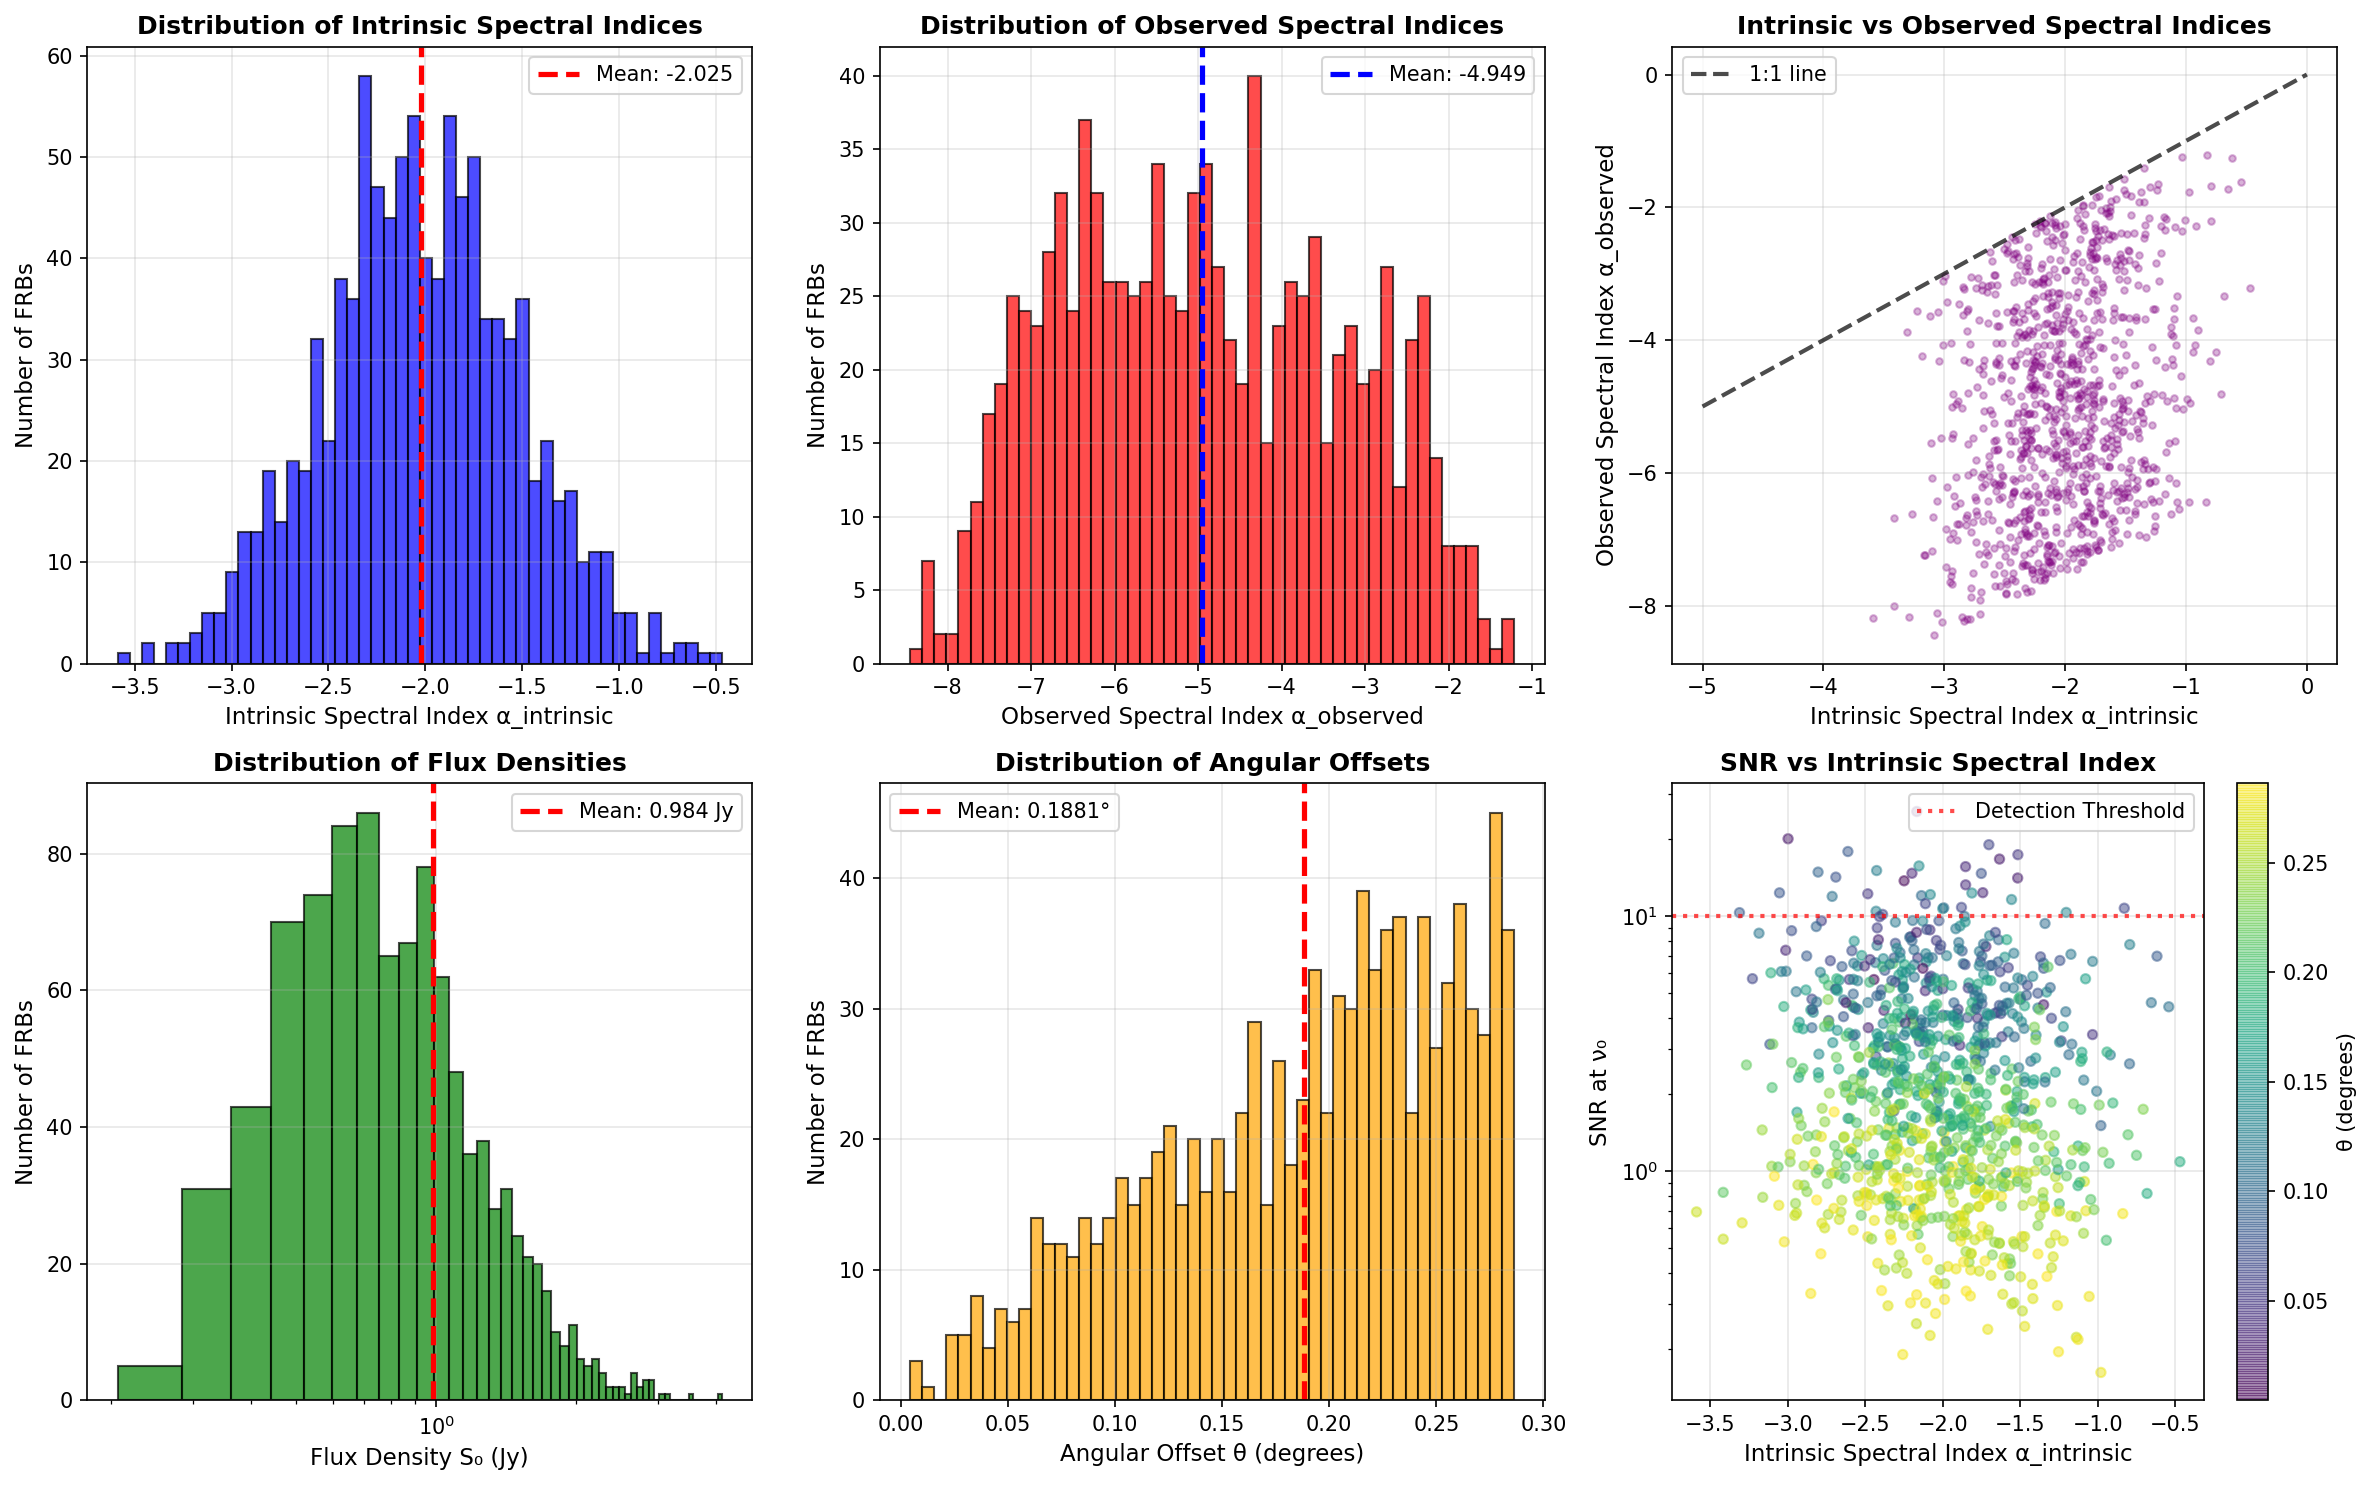


SPECTRAL INDEX ANALYSIS

Difference (α_obs - α_intrinsic):
  Mean:     -2.9242
  Median:   -3.0731
  Std Dev:  1.5883
  Min:      -5.6400
  Max:      -0.0016

Observations:
  - Intrinsic α spans from 0 to -5 (uniform distribution)
  - Observed α is affected by:
    • Frequency-dependent beam gain
    • Angular position (θ)
    • SNR variation across frequency band



In [19]:
# Plot histograms and comparisons
fig, axes = plt.subplots(2, 3, figsize=(16, 10), dpi=150)

# Plot 1: Intrinsic spectral index distribution
ax = axes[0, 0]
ax.hist(frb_alpha_intrinsic, bins=50, alpha=0.7, color='blue', edgecolor='black')
ax.axvline(np.mean(frb_alpha_intrinsic), color='red', linestyle='--', linewidth=2.5, 
           label=f'Mean: {np.mean(frb_alpha_intrinsic):.3f}')
ax.set_xlabel('Intrinsic Spectral Index α_intrinsic', fontsize=11)
ax.set_ylabel('Number of FRBs', fontsize=11)
ax.set_title('Distribution of Intrinsic Spectral Indices', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 2: Observed spectral index distribution
ax = axes[0, 1]
alpha_obs_valid = frb_alpha_inferred[~np.isnan(frb_alpha_inferred)]
ax.hist(alpha_obs_valid, bins=50, alpha=0.7, color='red', edgecolor='black')
ax.axvline(np.mean(alpha_obs_valid), color='blue', linestyle='--', linewidth=2.5, 
           label=f'Mean: {np.mean(alpha_obs_valid):.3f}')
ax.set_xlabel('Observed Spectral Index α_observed', fontsize=11)
ax.set_ylabel('Number of FRBs', fontsize=11)
ax.set_title('Distribution of Observed Spectral Indices', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 3: Intrinsic vs Observed (scatter)
ax = axes[0, 2]
ax.scatter(frb_alpha_intrinsic, frb_alpha_inferred, alpha=0.3, s=10, color='purple')
ax.plot([-5, 0], [-5, 0], 'k--', linewidth=2, label='1:1 line', alpha=0.7)
ax.set_xlabel('Intrinsic Spectral Index α_intrinsic', fontsize=11)
ax.set_ylabel('Observed Spectral Index α_observed', fontsize=11)
ax.set_title('Intrinsic vs Observed Spectral Indices', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 4: S0 distribution
ax = axes[1, 0]
ax.hist(frb_S0, bins=50, alpha=0.7, color='green', edgecolor='black')
ax.axvline(np.mean(frb_S0), color='red', linestyle='--', linewidth=2.5, 
           label=f'Mean: {np.mean(frb_S0):.3f} Jy')
ax.set_xlabel('Flux Density S₀ (Jy)', fontsize=11)
ax.set_ylabel('Number of FRBs', fontsize=11)
ax.set_title('Distribution of Flux Densities', fontsize=12, fontweight='bold')
ax.set_xscale('log')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 5: Angular offset distribution
ax = axes[1, 1]
ax.hist(np.degrees(frb_theta), bins=50, alpha=0.7, color='orange', edgecolor='black')
ax.axvline(np.degrees(np.mean(frb_theta)), color='red', linestyle='--', linewidth=2.5, 
           label=f'Mean: {np.degrees(np.mean(frb_theta)):.4f}°')
ax.set_xlabel('Angular Offset θ (degrees)', fontsize=11)
ax.set_ylabel('Number of FRBs', fontsize=11)
ax.set_title('Distribution of Angular Offsets', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 6: SNR vs intrinsic spectral index
ax = axes[1, 2]
scatter = ax.scatter(frb_alpha_intrinsic, frb_snr_coherent, c=np.degrees(frb_theta), 
                     cmap='viridis', alpha=0.5, s=20)
ax.axhline(y=10, color='red', linestyle=':', linewidth=2, label='Detection Threshold', alpha=0.7)
ax.set_xlabel('Intrinsic Spectral Index α_intrinsic', fontsize=11)
ax.set_ylabel('SNR at ν₀', fontsize=11)
ax.set_title('SNR vs Intrinsic Spectral Index', fontsize=12, fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('θ (degrees)', fontsize=10)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

plt.tight_layout()
plt.show()

# Print spectral index comparison
print("\n" + "=" * 80)
print("SPECTRAL INDEX ANALYSIS")
print("=" * 80)

delta_alpha = alpha_obs_valid - frb_alpha_intrinsic[:len(alpha_obs_valid)]
print(f"\nDifference (α_obs - α_intrinsic):")
print(f"  Mean:     {np.mean(delta_alpha):.4f}")
print(f"  Median:   {np.median(delta_alpha):.4f}")
print(f"  Std Dev:  {np.std(delta_alpha):.4f}")
print(f"  Min:      {np.min(delta_alpha):.4f}")
print(f"  Max:      {np.max(delta_alpha):.4f}")

print(f"\nObservations:")
print(f"  - Intrinsic α spans from 0 to -5 (uniform distribution)")
print(f"  - Observed α is affected by:")
print(f"    • Frequency-dependent beam gain")
print(f"    • Angular position (θ)")
print(f"    • SNR variation across frequency band")
print("\n" + "=" * 80)

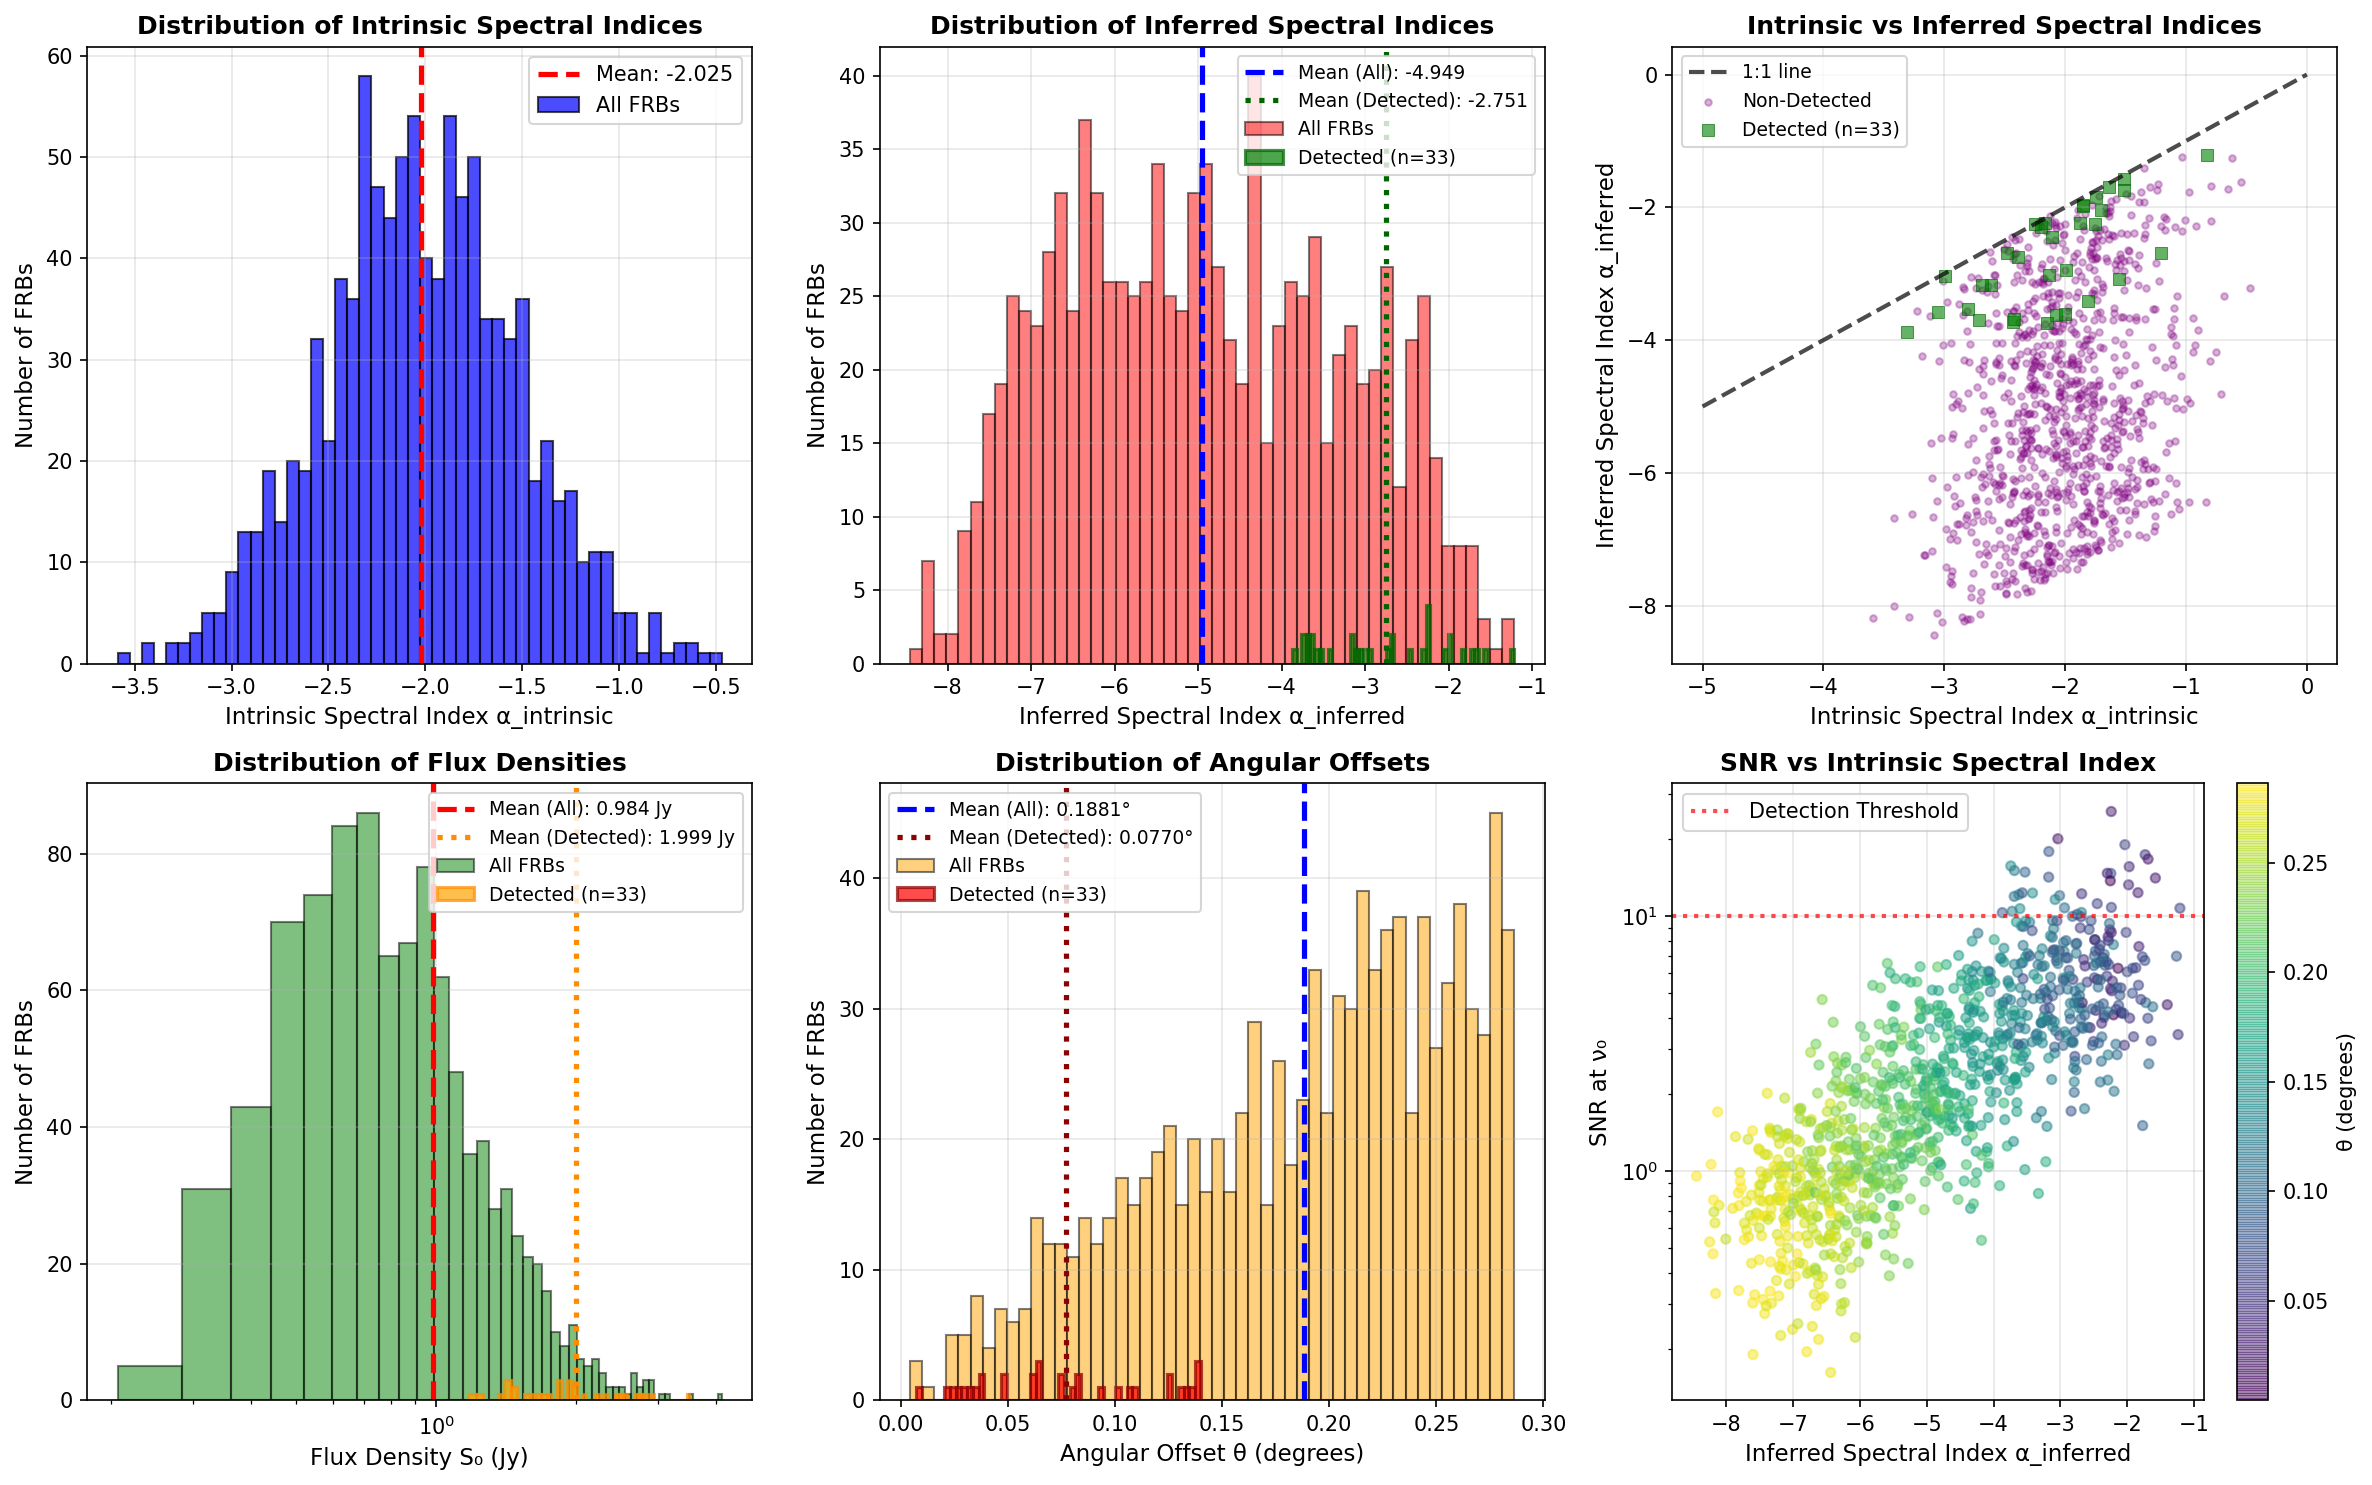

In [20]:
# Plot histograms and comparisons
fig, axes = plt.subplots(2, 3, figsize=(16, 10), dpi=150)

# Plot 1: Intrinsic spectral index distribution
ax = axes[0, 0]
ax.hist(frb_alpha_intrinsic, bins=50, alpha=0.7, color='blue', edgecolor='black', label='All FRBs')
ax.axvline(np.mean(frb_alpha_intrinsic), color='red', linestyle='--', linewidth=2.5, 
           label=f'Mean: {np.mean(frb_alpha_intrinsic):.3f}')
ax.set_xlabel('Intrinsic Spectral Index α_intrinsic', fontsize=11)
ax.set_ylabel('Number of FRBs', fontsize=11)
ax.set_title('Distribution of Intrinsic Spectral Indices', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 2: Inferred spectral index distribution (with detected overlay)
ax = axes[0, 1]
alpha_inferred_valid = frb_alpha_inferred[~np.isnan(frb_alpha_inferred)]
ax.hist(alpha_inferred_valid, bins=50, alpha=0.5, color='red', edgecolor='black', label='All FRBs')

# Overlay histogram of detected FRBs
alpha_inferred_detected = frb_alpha_inferred[frb_detected & ~np.isnan(frb_alpha_inferred)]
ax.hist(alpha_inferred_detected, bins=50, alpha=0.7, color='green', edgecolor='darkgreen', 
        linewidth=1.5, label=f'Detected (n={len(alpha_inferred_detected)})')

ax.axvline(np.mean(alpha_inferred_valid), color='blue', linestyle='--', linewidth=2.5, 
           label=f'Mean (All): {np.mean(alpha_inferred_valid):.3f}')
ax.axvline(np.mean(alpha_inferred_detected), color='darkgreen', linestyle=':', linewidth=2.5, 
           label=f'Mean (Detected): {np.mean(alpha_inferred_detected):.3f}')
ax.set_xlabel('Inferred Spectral Index α_inferred', fontsize=11)
ax.set_ylabel('Number of FRBs', fontsize=11)
ax.set_title('Distribution of Inferred Spectral Indices', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 3: Intrinsic vs Inferred (scatter with detected labeled)
ax = axes[0, 2]
# Plot non-detected FRBs
non_detected_mask = ~frb_detected & ~np.isnan(frb_alpha_inferred)
ax.scatter(frb_alpha_intrinsic[non_detected_mask], frb_alpha_inferred[non_detected_mask], 
           alpha=0.3, s=10, color='purple', label='Non-Detected')

# Plot detected FRBs with different color/marker
detected_mask = frb_detected & ~np.isnan(frb_alpha_inferred)
ax.scatter(frb_alpha_intrinsic[detected_mask], frb_alpha_inferred[detected_mask], 
           alpha=0.6, s=30, color='green', marker='s', edgecolor='darkgreen', linewidth=0.5,
           label=f'Detected (n={np.sum(detected_mask)})')

ax.plot([-5, 0], [-5, 0], 'k--', linewidth=2, label='1:1 line', alpha=0.7)
ax.set_xlabel('Intrinsic Spectral Index α_intrinsic', fontsize=11)
ax.set_ylabel('Inferred Spectral Index α_inferred', fontsize=11)
ax.set_title('Intrinsic vs Inferred Spectral Indices', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 4: S0 distribution (with detected overlay)
ax = axes[1, 0]
ax.hist(frb_S0, bins=50, alpha=0.5, color='green', edgecolor='black', label='All FRBs')

# Overlay histogram of detected FRBs
S0_detected = frb_S0[frb_detected]
ax.hist(S0_detected, bins=50, alpha=0.7, color='orange', edgecolor='darkorange', 
        linewidth=1.5, label=f'Detected (n={len(S0_detected)})')

ax.axvline(np.mean(frb_S0), color='red', linestyle='--', linewidth=2.5, 
           label=f'Mean (All): {np.mean(frb_S0):.3f} Jy')
ax.axvline(np.mean(S0_detected), color='darkorange', linestyle=':', linewidth=2.5, 
           label=f'Mean (Detected): {np.mean(S0_detected):.3f} Jy')
ax.set_xlabel('Flux Density S₀ (Jy)', fontsize=11)
ax.set_ylabel('Number of FRBs', fontsize=11)
ax.set_title('Distribution of Flux Densities', fontsize=12, fontweight='bold')
ax.set_xscale('log')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 5: Angular offset distribution (with detected overlay)
ax = axes[1, 1]
ax.hist(np.degrees(frb_theta), bins=50, alpha=0.5, color='orange', edgecolor='black', label='All FRBs')

# Overlay histogram of detected FRBs
theta_detected = np.degrees(frb_theta[frb_detected])
ax.hist(theta_detected, bins=50, alpha=0.7, color='red', edgecolor='darkred', 
        linewidth=1.5, label=f'Detected (n={len(theta_detected)})')

ax.axvline(np.degrees(np.mean(frb_theta)), color='blue', linestyle='--', linewidth=2.5, 
           label=f'Mean (All): {np.degrees(np.mean(frb_theta)):.4f}°')
ax.axvline(np.degrees(np.mean(frb_theta[frb_detected])), color='darkred', linestyle=':', linewidth=2.5, 
           label=f'Mean (Detected): {np.degrees(np.mean(frb_theta[frb_detected])):.4f}°')
ax.set_xlabel('Angular Offset θ (degrees)', fontsize=11)
ax.set_ylabel('Number of FRBs', fontsize=11)
ax.set_title('Distribution of Angular Offsets', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 6: SNR vs intrinsic spectral index
ax = axes[1, 2]
scatter = ax.scatter(frb_alpha_inferred, frb_snr_coherent, c=np.degrees(frb_theta), 
                     cmap='viridis', alpha=0.5, s=20)
ax.axhline(y=10, color='red', linestyle=':', linewidth=2, label='Detection Threshold', alpha=0.7)
ax.set_xlabel('Inferred Spectral Index α_inferred', fontsize=11)
ax.set_ylabel('SNR at ν₀', fontsize=11)
ax.set_title('SNR vs Intrinsic Spectral Index', fontsize=12, fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('θ (degrees)', fontsize=10)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

plt.tight_layout()
plt.show()



In [21]:
# Half Gaussian

frb_S0 = []  # Flux density at reference frequency (log-normal)
frb_alpha_intrinsic = []  # Intrinsic spectral index (Gaussian centered at -2)
frb_theta = []  # Angular offset (Gaussian distribution)
frb_alpha_inferred = []  # Observed spectral index (fitted)
frb_snr = []  # SNR at reference frequency
frb_detected = []  # Detection flag
frb_snr_coherent = [] 

# Generate FRBs
for i in range(n_frb):
    if (i + 1) % 2000 == 0:
        print(f"  Processing FRB {i+1}/{n_frb}...")
    
    # S0: Log-normal distribution
    mu = np.log(S0_mean) - S0_sigma**2 / 2.0
    S0_frb = np.random.lognormal(mean=mu, sigma=S0_sigma)
    frb_S0.append(S0_frb)
    
    # Intrinsic spectral index: Half-Gaussian (folded normal) centered at 0
    # Generate from normal, take absolute value (fold at 0)
    alpha_intrinsic = -np.abs(np.random.normal(loc=alpha_mean, scale=alpha_sigma))
    frb_alpha_intrinsic.append(alpha_intrinsic)
    
    # Angular offset: Gaussian distribution
    theta_frb = theta_max * np.sqrt(np.random.random())
    theta_frb = np.abs(theta_frb)  # Ensure positive
    frb_theta.append(theta_frb)
    
    # Calculate SNR spectrum across frequency band
    snr_spectrum = []
    for nu in nu_array:
        S_nu = S0_frb * (nu / nu0)**alpha_intrinsic
        G_nu = gaussian_beam_gain(nu, G0, theta_frb, D, c)
        snr_val = SNR(S_nu, t, G_nu, BW, Np, Trec, Tsky)
        snr_spectrum.append(snr_val)
    
    snr_spectrum = np.array(snr_spectrum)
    
    # SNR at reference frequency
    S_nu0 = S0_frb
    G_nu0 = gaussian_beam_gain(nu0, G0, theta_frb, D, c)
    snr_nu0 = SNR(S_nu0, t, G_nu0, BW, Np, Trec, Tsky)
    frb_snr.append(snr_nu0)
    
    # Detection criterion
    snr_coherent = np.sqrt(np.sum(snr_spectrum**2) / len(snr_spectrum))
    frb_snr_coherent.append(snr_coherent) 
    frb_detected.append(snr_coherent > 10)
    
    # Fit observed spectral index: SNR ∝ ν^α_obs
    try:
        def power_law(nu, a, b):
            return a * (nu ** b)
        
        popt, _ = curve_fit(power_law, nu_array, snr_spectrum, 
                           p0=[1e-20, 2], maxfev=5000)
        a_fit, alpha_observed = popt
        frb_alpha_inferred.append(alpha_observed)
    except:
        frb_alpha_inferred.append(np.nan)

# Convert to arrays
frb_S0 = np.array(frb_S0)
frb_alpha_intrinsic = np.array(frb_alpha_intrinsic)
frb_theta = np.array(frb_theta)
frb_alpha_inferred = np.array(frb_alpha_inferred)
frb_snr = np.array(frb_snr)
frb_detected = np.array(frb_detected)

n_detected = np.sum(frb_detected)
detection_rate = n_detected / n_frb * 100


alpha_obs_valid = frb_alpha_inferred[~np.isnan(frb_alpha_inferred)]
frb_detected_half = frb_detected

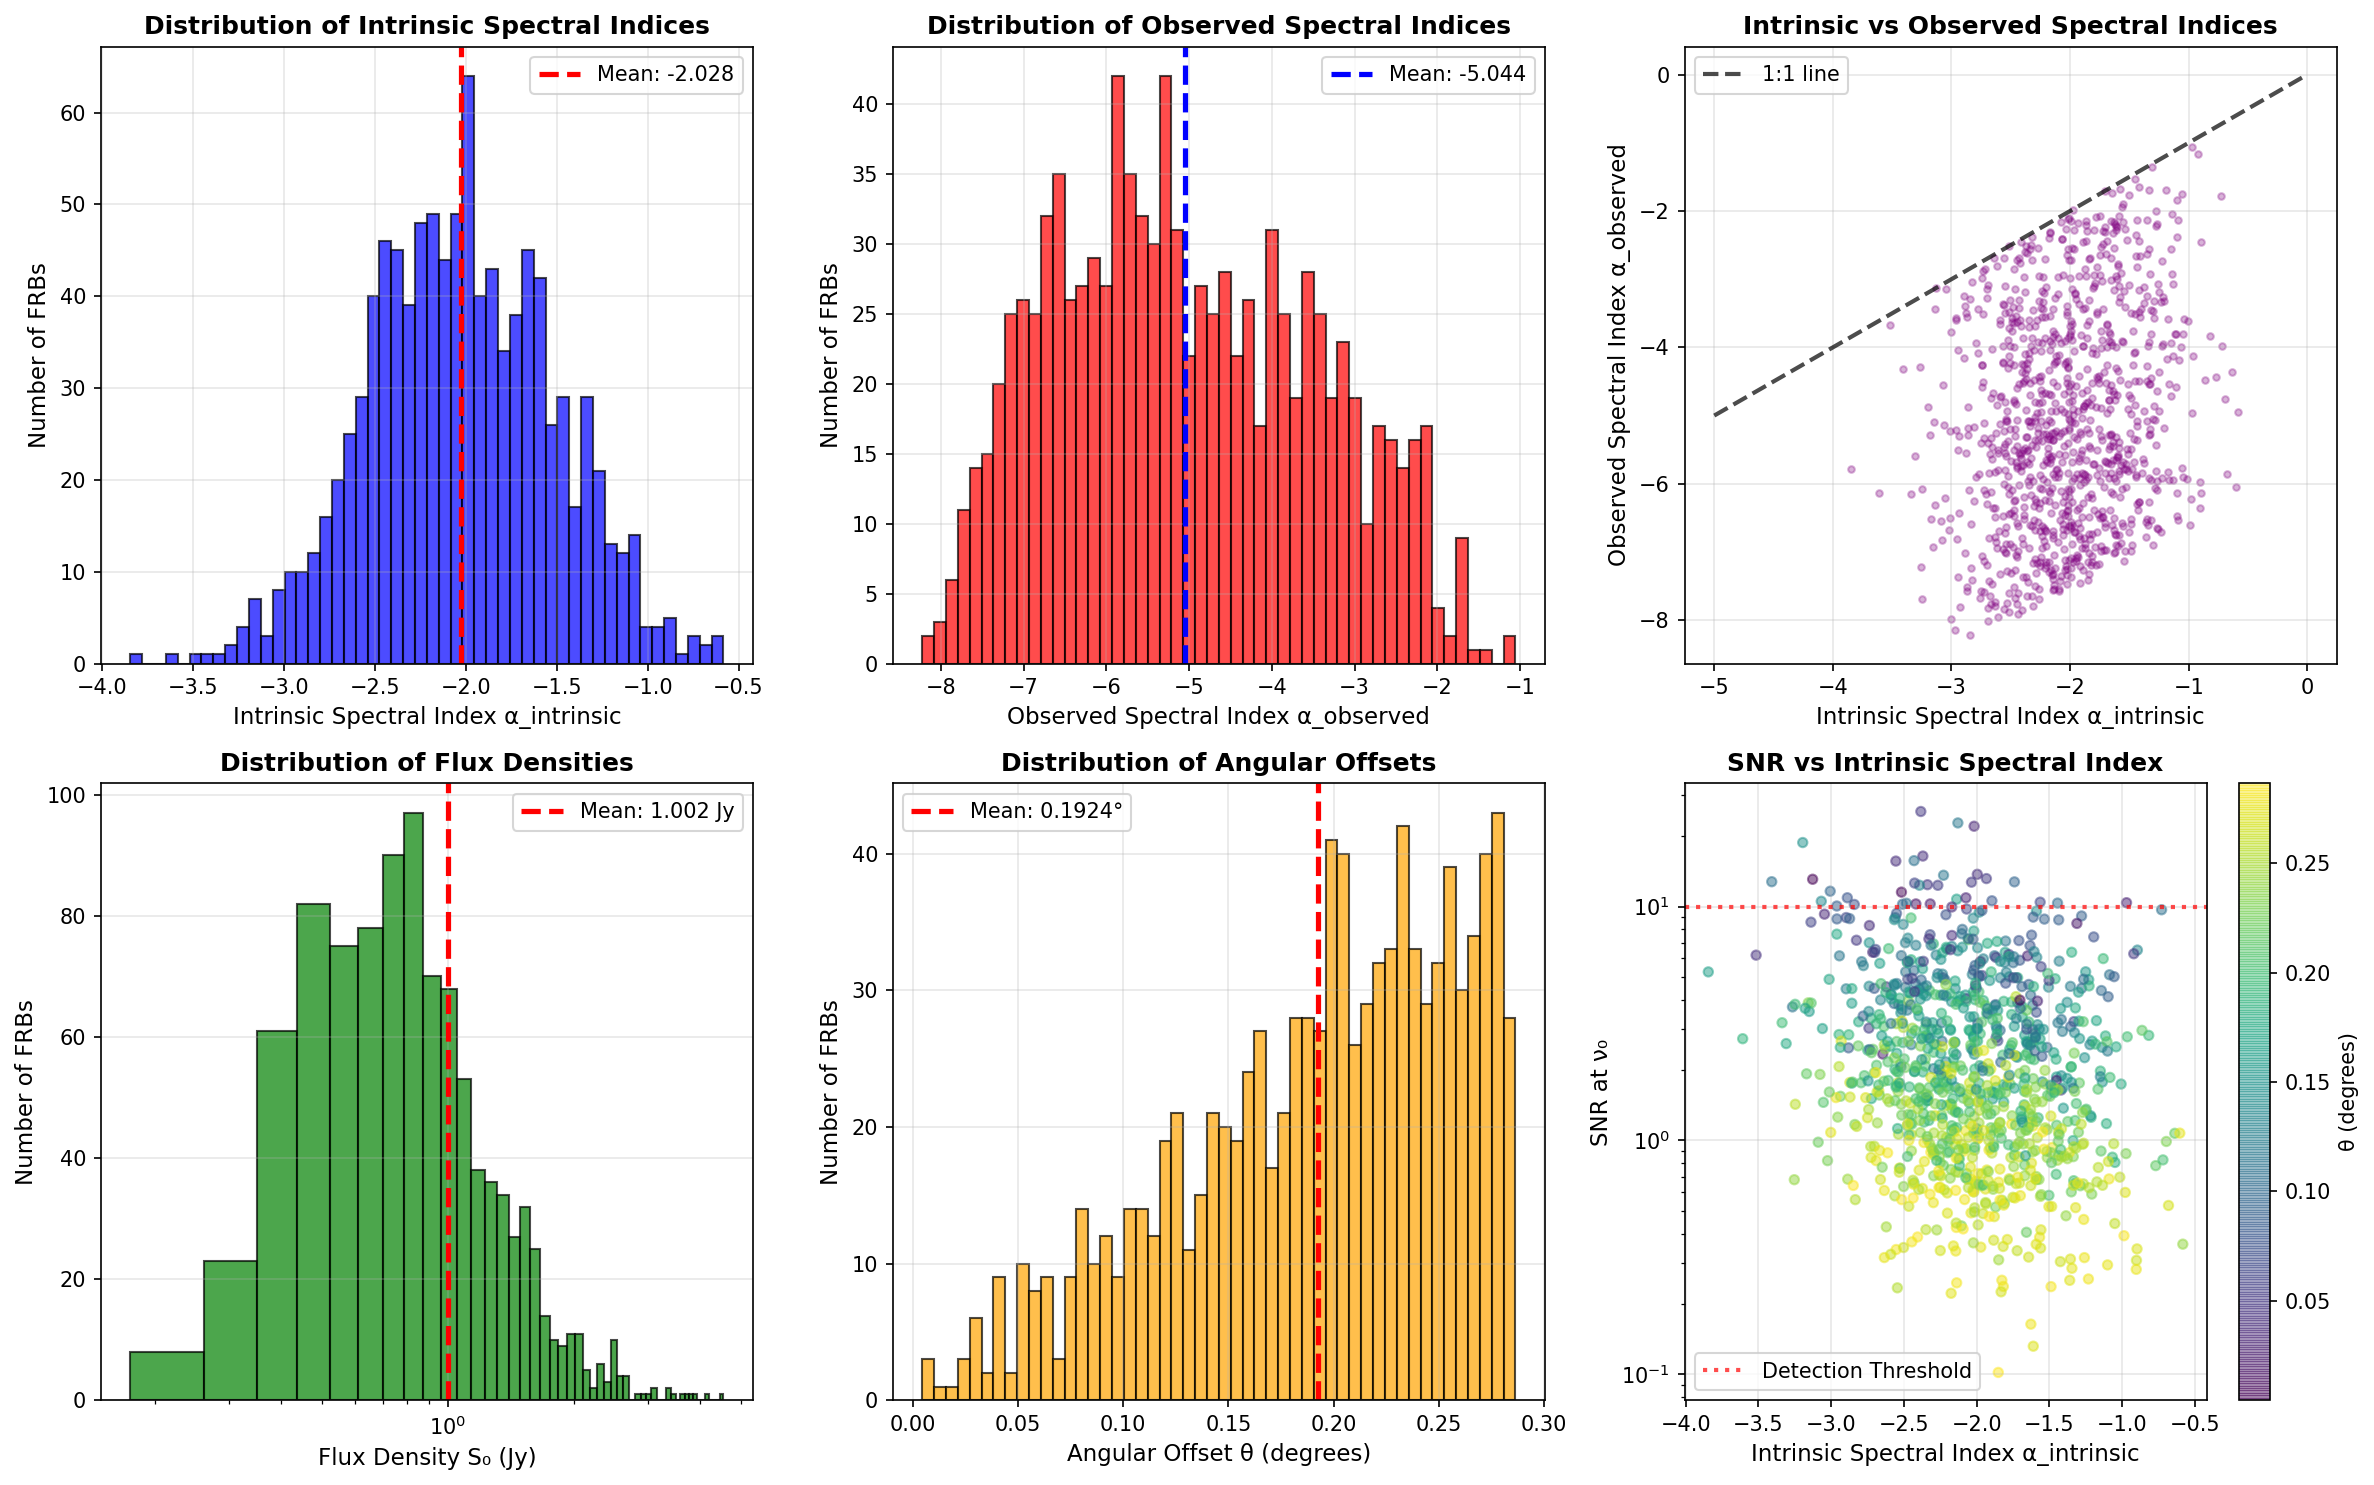


SPECTRAL INDEX ANALYSIS

Difference (α_obs - α_intrinsic):
  Mean:     -3.0158
  Median:   -3.1147
  Std Dev:  1.5334
  Min:      -5.6141
  Max:      -0.0017

Observations:
  - Intrinsic α spans from 0 to -5 (uniform distribution)
  - Observed α is affected by:
    • Frequency-dependent beam gain
    • Angular position (θ)
    • SNR variation across frequency band



In [22]:
# Plot histograms and comparisons
fig, axes = plt.subplots(2, 3, figsize=(16, 10), dpi=150)

# Plot 1: Intrinsic spectral index distribution
ax = axes[0, 0]
ax.hist(frb_alpha_intrinsic, bins=50, alpha=0.7, color='blue', edgecolor='black')
ax.axvline(np.mean(frb_alpha_intrinsic), color='red', linestyle='--', linewidth=2.5, 
           label=f'Mean: {np.mean(frb_alpha_intrinsic):.3f}')
ax.set_xlabel('Intrinsic Spectral Index α_intrinsic', fontsize=11)
ax.set_ylabel('Number of FRBs', fontsize=11)
ax.set_title('Distribution of Intrinsic Spectral Indices', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 2: Observed spectral index distribution
ax = axes[0, 1]
alpha_obs_valid = frb_alpha_inferred[~np.isnan(frb_alpha_inferred)]
ax.hist(alpha_obs_valid, bins=50, alpha=0.7, color='red', edgecolor='black')
ax.axvline(np.mean(alpha_obs_valid), color='blue', linestyle='--', linewidth=2.5, 
           label=f'Mean: {np.mean(alpha_obs_valid):.3f}')
ax.set_xlabel('Observed Spectral Index α_observed', fontsize=11)
ax.set_ylabel('Number of FRBs', fontsize=11)
ax.set_title('Distribution of Observed Spectral Indices', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 3: Intrinsic vs Observed (scatter)
ax = axes[0, 2]
ax.scatter(frb_alpha_intrinsic, frb_alpha_inferred, alpha=0.3, s=10, color='purple')
ax.plot([-5, 0], [-5, 0], 'k--', linewidth=2, label='1:1 line', alpha=0.7)
ax.set_xlabel('Intrinsic Spectral Index α_intrinsic', fontsize=11)
ax.set_ylabel('Observed Spectral Index α_observed', fontsize=11)
ax.set_title('Intrinsic vs Observed Spectral Indices', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 4: S0 distribution
ax = axes[1, 0]
ax.hist(frb_S0, bins=50, alpha=0.7, color='green', edgecolor='black')
ax.axvline(np.mean(frb_S0), color='red', linestyle='--', linewidth=2.5, 
           label=f'Mean: {np.mean(frb_S0):.3f} Jy')
ax.set_xlabel('Flux Density S₀ (Jy)', fontsize=11)
ax.set_ylabel('Number of FRBs', fontsize=11)
ax.set_title('Distribution of Flux Densities', fontsize=12, fontweight='bold')
ax.set_xscale('log')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 5: Angular offset distribution
ax = axes[1, 1]
ax.hist(np.degrees(frb_theta), bins=50, alpha=0.7, color='orange', edgecolor='black')
ax.axvline(np.degrees(np.mean(frb_theta)), color='red', linestyle='--', linewidth=2.5, 
           label=f'Mean: {np.degrees(np.mean(frb_theta)):.4f}°')
ax.set_xlabel('Angular Offset θ (degrees)', fontsize=11)
ax.set_ylabel('Number of FRBs', fontsize=11)
ax.set_title('Distribution of Angular Offsets', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 6: SNR vs intrinsic spectral index
ax = axes[1, 2]
scatter = ax.scatter(frb_alpha_intrinsic, frb_snr_coherent, c=np.degrees(frb_theta), 
                     cmap='viridis', alpha=0.5, s=20)
ax.axhline(y=10, color='red', linestyle=':', linewidth=2, label='Detection Threshold', alpha=0.7)
ax.set_xlabel('Intrinsic Spectral Index α_intrinsic', fontsize=11)
ax.set_ylabel('SNR at ν₀', fontsize=11)
ax.set_title('SNR vs Intrinsic Spectral Index', fontsize=12, fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('θ (degrees)', fontsize=10)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

plt.tight_layout()
plt.show()

# Print spectral index comparison
print("\n" + "=" * 80)
print("SPECTRAL INDEX ANALYSIS")
print("=" * 80)

delta_alpha = alpha_obs_valid - frb_alpha_intrinsic[:len(alpha_obs_valid)]
print(f"\nDifference (α_obs - α_intrinsic):")
print(f"  Mean:     {np.mean(delta_alpha):.4f}")
print(f"  Median:   {np.median(delta_alpha):.4f}")
print(f"  Std Dev:  {np.std(delta_alpha):.4f}")
print(f"  Min:      {np.min(delta_alpha):.4f}")
print(f"  Max:      {np.max(delta_alpha):.4f}")

print(f"\nObservations:")
print(f"  - Intrinsic α spans from 0 to -5 (uniform distribution)")
print(f"  - Observed α is affected by:")
print(f"    • Frequency-dependent beam gain")
print(f"    • Angular position (θ)")
print(f"    • SNR variation across frequency band")
print("\n" + "=" * 80)

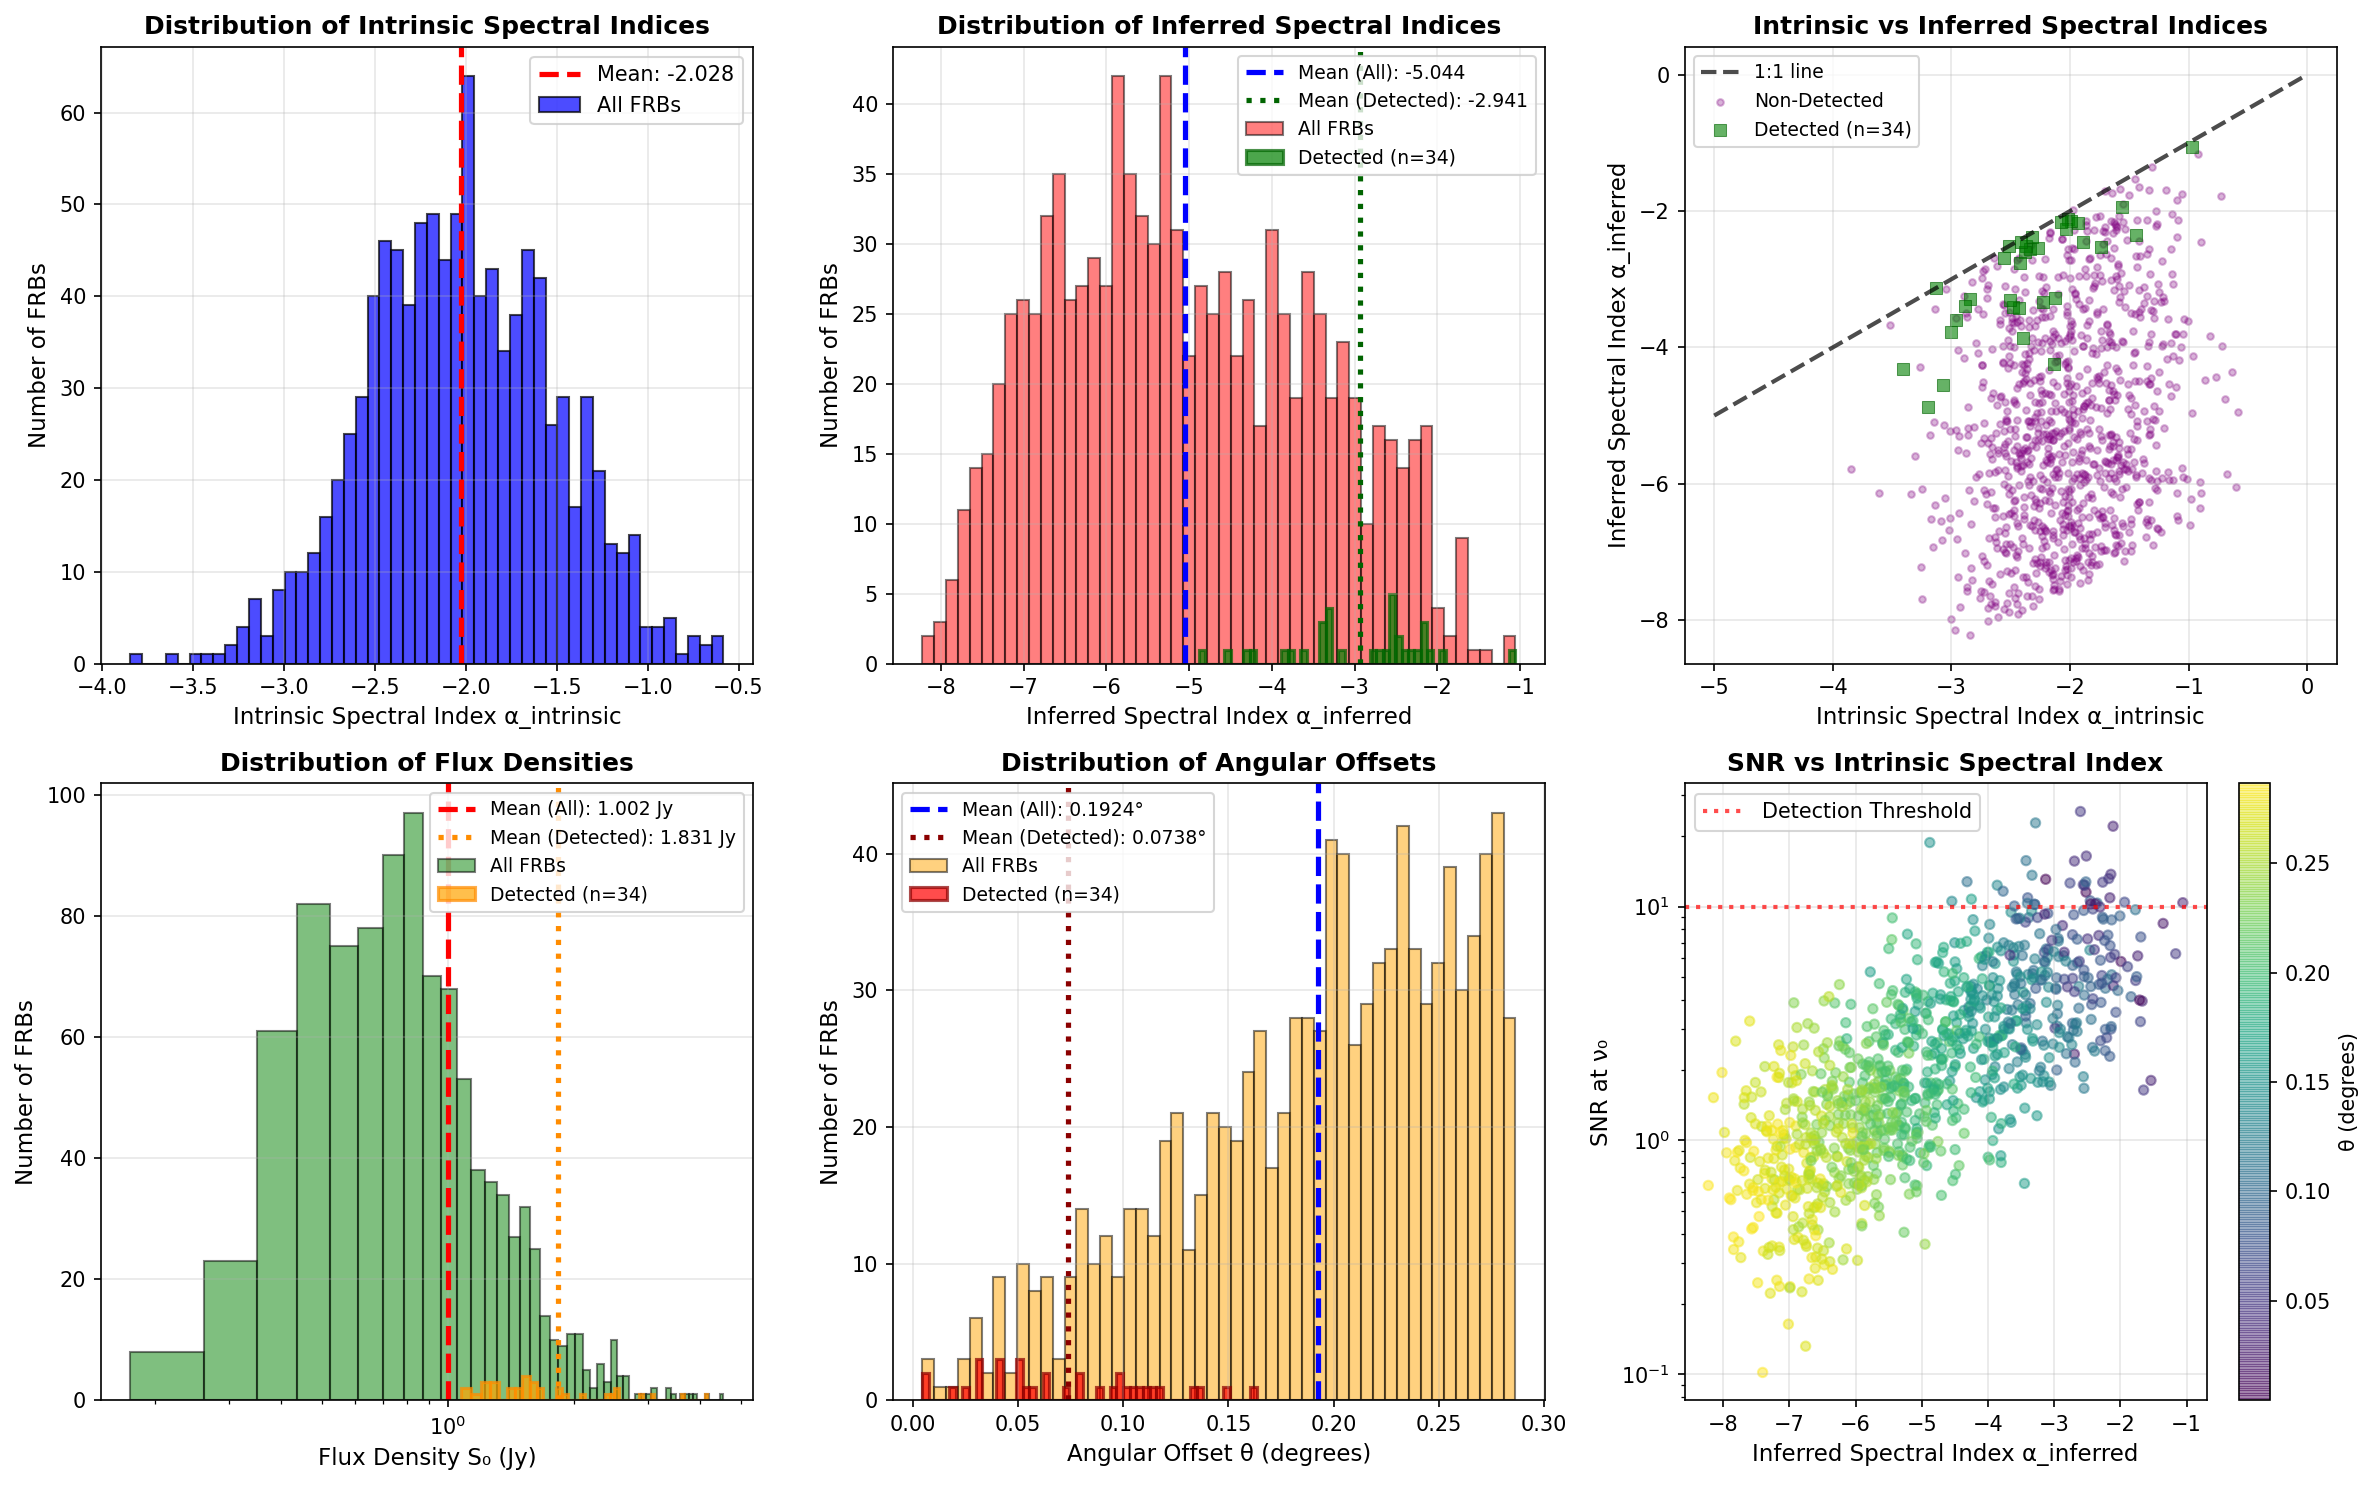

In [23]:
# Plot histograms and comparisons
fig, axes = plt.subplots(2, 3, figsize=(16, 10), dpi=150)

# Plot 1: Intrinsic spectral index distribution
ax = axes[0, 0]
ax.hist(frb_alpha_intrinsic, bins=50, alpha=0.7, color='blue', edgecolor='black', label='All FRBs')
ax.axvline(np.mean(frb_alpha_intrinsic), color='red', linestyle='--', linewidth=2.5, 
           label=f'Mean: {np.mean(frb_alpha_intrinsic):.3f}')
ax.set_xlabel('Intrinsic Spectral Index α_intrinsic', fontsize=11)
ax.set_ylabel('Number of FRBs', fontsize=11)
ax.set_title('Distribution of Intrinsic Spectral Indices', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 2: Inferred spectral index distribution (with detected overlay)
ax = axes[0, 1]
alpha_inferred_valid = frb_alpha_inferred[~np.isnan(frb_alpha_inferred)]
ax.hist(alpha_inferred_valid, bins=50, alpha=0.5, color='red', edgecolor='black', label='All FRBs')

# Overlay histogram of detected FRBs
alpha_inferred_detected = frb_alpha_inferred[frb_detected & ~np.isnan(frb_alpha_inferred)]
ax.hist(alpha_inferred_detected, bins=50, alpha=0.7, color='green', edgecolor='darkgreen', 
        linewidth=1.5, label=f'Detected (n={len(alpha_inferred_detected)})')

ax.axvline(np.mean(alpha_inferred_valid), color='blue', linestyle='--', linewidth=2.5, 
           label=f'Mean (All): {np.mean(alpha_inferred_valid):.3f}')
ax.axvline(np.mean(alpha_inferred_detected), color='darkgreen', linestyle=':', linewidth=2.5, 
           label=f'Mean (Detected): {np.mean(alpha_inferred_detected):.3f}')
ax.set_xlabel('Inferred Spectral Index α_inferred', fontsize=11)
ax.set_ylabel('Number of FRBs', fontsize=11)
ax.set_title('Distribution of Inferred Spectral Indices', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 3: Intrinsic vs Inferred (scatter with detected labeled)
ax = axes[0, 2]
# Plot non-detected FRBs
non_detected_mask = ~frb_detected & ~np.isnan(frb_alpha_inferred)
ax.scatter(frb_alpha_intrinsic[non_detected_mask], frb_alpha_inferred[non_detected_mask], 
           alpha=0.3, s=10, color='purple', label='Non-Detected')

# Plot detected FRBs with different color/marker
detected_mask = frb_detected & ~np.isnan(frb_alpha_inferred)
ax.scatter(frb_alpha_intrinsic[detected_mask], frb_alpha_inferred[detected_mask], 
           alpha=0.6, s=30, color='green', marker='s', edgecolor='darkgreen', linewidth=0.5,
           label=f'Detected (n={np.sum(detected_mask)})')

ax.plot([-5, 0], [-5, 0], 'k--', linewidth=2, label='1:1 line', alpha=0.7)
ax.set_xlabel('Intrinsic Spectral Index α_intrinsic', fontsize=11)
ax.set_ylabel('Inferred Spectral Index α_inferred', fontsize=11)
ax.set_title('Intrinsic vs Inferred Spectral Indices', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 4: S0 distribution (with detected overlay)
ax = axes[1, 0]
ax.hist(frb_S0, bins=50, alpha=0.5, color='green', edgecolor='black', label='All FRBs')

# Overlay histogram of detected FRBs
S0_detected = frb_S0[frb_detected]
ax.hist(S0_detected, bins=50, alpha=0.7, color='orange', edgecolor='darkorange', 
        linewidth=1.5, label=f'Detected (n={len(S0_detected)})')

ax.axvline(np.mean(frb_S0), color='red', linestyle='--', linewidth=2.5, 
           label=f'Mean (All): {np.mean(frb_S0):.3f} Jy')
ax.axvline(np.mean(S0_detected), color='darkorange', linestyle=':', linewidth=2.5, 
           label=f'Mean (Detected): {np.mean(S0_detected):.3f} Jy')
ax.set_xlabel('Flux Density S₀ (Jy)', fontsize=11)
ax.set_ylabel('Number of FRBs', fontsize=11)
ax.set_title('Distribution of Flux Densities', fontsize=12, fontweight='bold')
ax.set_xscale('log')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 5: Angular offset distribution (with detected overlay)
ax = axes[1, 1]
ax.hist(np.degrees(frb_theta), bins=50, alpha=0.5, color='orange', edgecolor='black', label='All FRBs')

# Overlay histogram of detected FRBs
theta_detected = np.degrees(frb_theta[frb_detected])
ax.hist(theta_detected, bins=50, alpha=0.7, color='red', edgecolor='darkred', 
        linewidth=1.5, label=f'Detected (n={len(theta_detected)})')

ax.axvline(np.degrees(np.mean(frb_theta)), color='blue', linestyle='--', linewidth=2.5, 
           label=f'Mean (All): {np.degrees(np.mean(frb_theta)):.4f}°')
ax.axvline(np.degrees(np.mean(frb_theta[frb_detected])), color='darkred', linestyle=':', linewidth=2.5, 
           label=f'Mean (Detected): {np.degrees(np.mean(frb_theta[frb_detected])):.4f}°')
ax.set_xlabel('Angular Offset θ (degrees)', fontsize=11)
ax.set_ylabel('Number of FRBs', fontsize=11)
ax.set_title('Distribution of Angular Offsets', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 6: SNR vs intrinsic spectral index
ax = axes[1, 2]
scatter = ax.scatter(frb_alpha_inferred, frb_snr_coherent, c=np.degrees(frb_theta), 
                     cmap='viridis', alpha=0.5, s=20)
ax.axhline(y=10, color='red', linestyle=':', linewidth=2, label='Detection Threshold', alpha=0.7)
ax.set_xlabel('Inferred Spectral Index α_inferred', fontsize=11)
ax.set_ylabel('SNR at ν₀', fontsize=11)
ax.set_title('SNR vs Intrinsic Spectral Index', fontsize=12, fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('θ (degrees)', fontsize=10)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

plt.tight_layout()
plt.show()



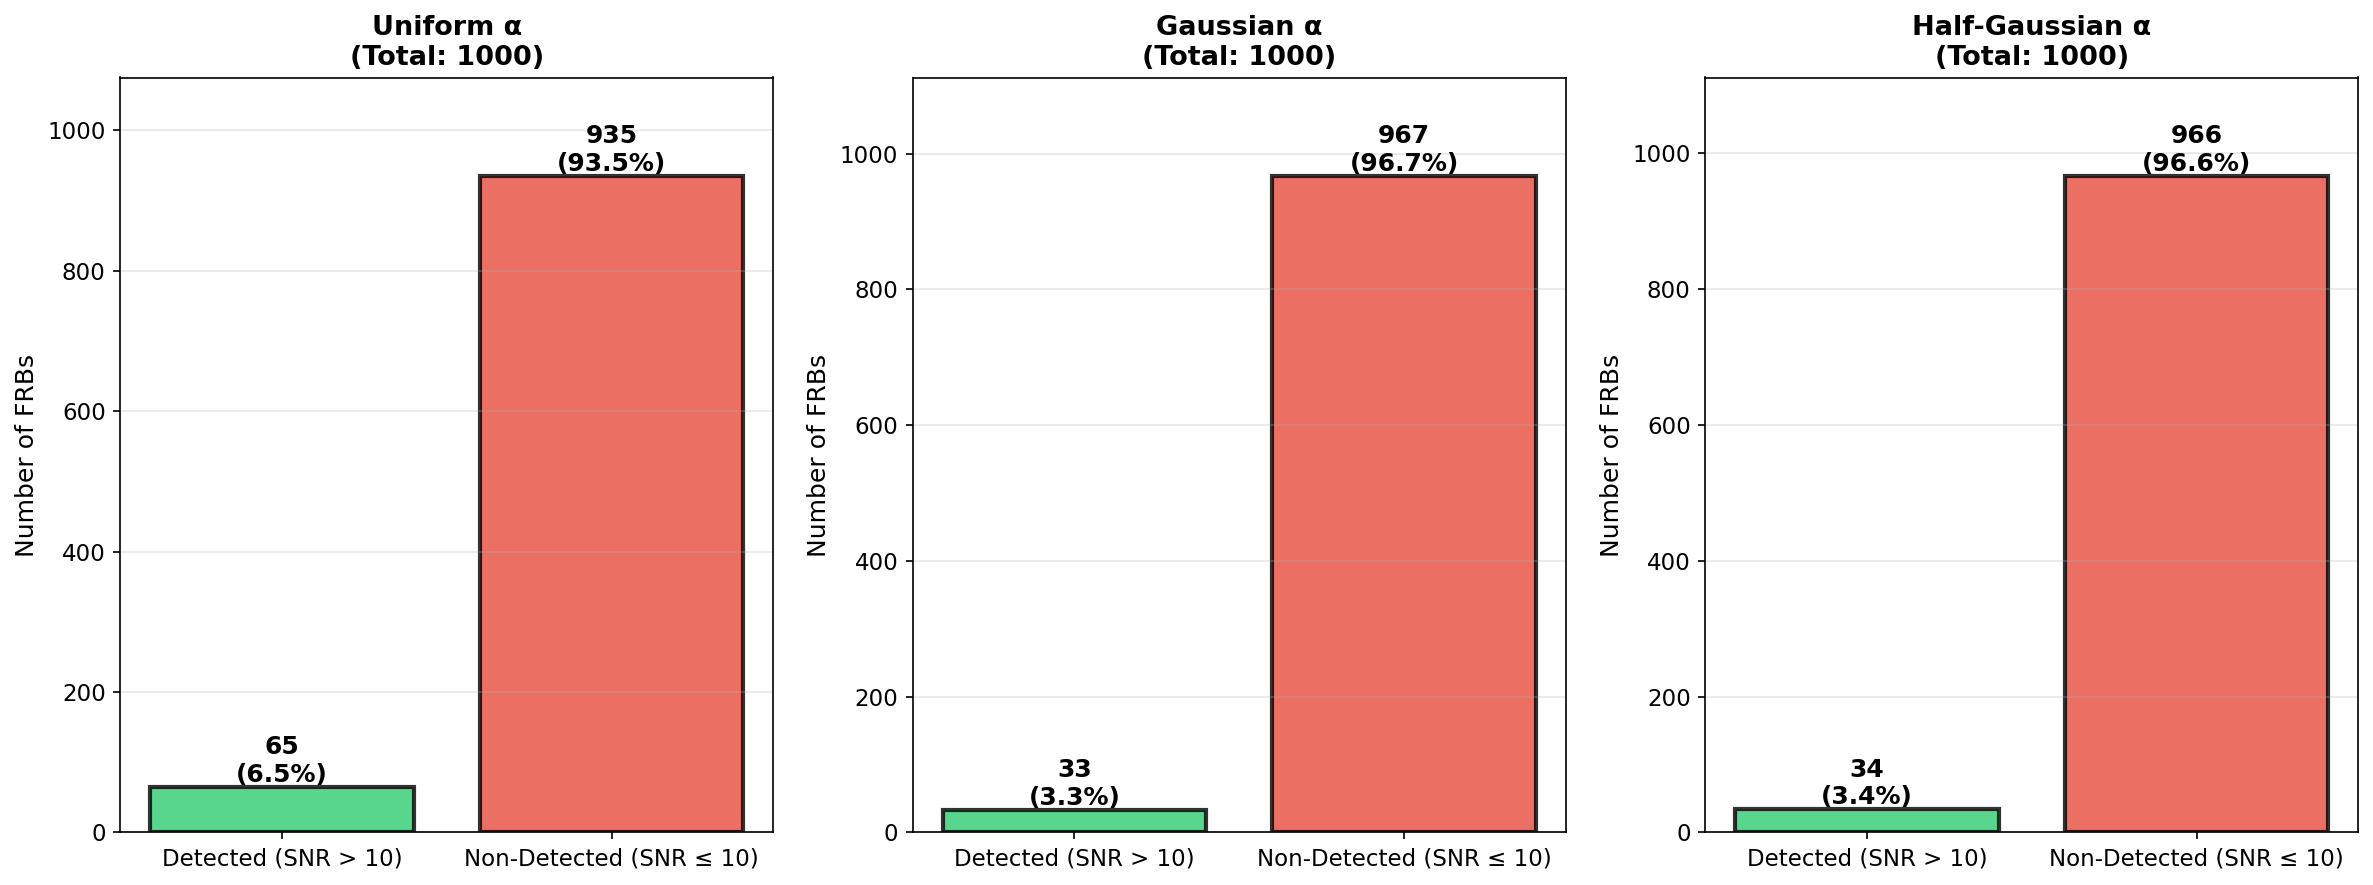


DETECTION STATISTICS SUMMARY
Population                Total      Detected     Non-Detected    Detection Rate
--------------------------------------------------------------------------------
Uniform α                 1000       34           966             3.40%


In [24]:
# Create detection statistics visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 6), dpi=150)

# Data for all three populations
populations = [
    ('Uniform α', frb_detected_flat),
    ('Gaussian α', frb_detected_norm),
    ('Half-Gaussian α', frb_detected_half)
]

colors = ['#2ecc71', '#e74c3c']  # Green for detected, Red for non-detected
labels = ['Detected (SNR > 10)', 'Non-Detected (SNR ≤ 10)']

for idx, (pop_name, detected_flags) in enumerate(populations):
    ax = axes[idx]
    
    # Count detected and non-detected
    n_detected = np.sum(detected_flags)
    n_non_detected = len(detected_flags) - n_detected
    
    counts = [n_detected, n_non_detected]
    percentages = [n_detected / len(detected_flags) * 100, 
                   n_non_detected / len(detected_flags) * 100]
    
    # Create bar plot
    bars = ax.bar(labels, counts, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    
    # Add count labels on bars
    for bar, count, pct in zip(bars, counts, percentages):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(count)}\n({pct:.1f}%)',
                ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    ax.set_ylabel('Number of FRBs', fontsize=12)
    ax.set_title(f'{pop_name}\n(Total: {len(detected_flags)})', 
                fontsize=13, fontweight='bold')
    ax.set_ylim([0, max(counts) * 1.15])
    ax.grid(True, alpha=0.3, axis='y')
    ax.tick_params(axis='both', which='major', labelsize=11)

plt.tight_layout()
plt.show()

# Print detection statistics table
print("\n" + "=" * 80)
print("DETECTION STATISTICS SUMMARY")
print("=" * 80)
print(f"{'Population':<25} {'Total':<10} {'Detected':<12} {'Non-Detected':<15} {'Detection Rate'}")
print("-" * 80)
print(f"{'Uniform α':<25} {n_frb:<10} {n_detected:<12} {n_non_detected:<15} {detection_rate:.2f}%")
